# **NOTEBOOK FOR `ANALYSIS` OF `OULAD` DATA**
***

- ***Goal is to find student dropout factors***

## ***Starting of Analysis***

### ***Data Import, Creating Connection and Checking the data***

In [110]:
import os
from pathlib import Path

def get_project_root(project_name="portfolio_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

data_path = repo_root / "beyond_oulad_student_dropout"
print(data_path)

C:\Users\Rano's PC\Machine\PORTFOLIO_PROJECTS\beyond_oulad_student_dropout


In [111]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
file_path = data_path / "dataset" / "processed_data" / "processed_oulad_data.csv"

data = pd.read_csv(file_path)

In [114]:
data.head()

module presentation gender student_region qualification imd_band age_band  \
0    AAA        2013J      M    East Anglia            HE  90-100%     55<=   
1    AAA        2013J      F       Scotland            HE   20-30%    35-55   
2    AAA        2013J      F     North West       A Level   30-40%    35-55   
3    AAA        2013J      F     South East       A Level   50-60%    35-55   
4    AAA        2013J      F  West Midlands       Below A   50-60%     0-35   

   prev_attempts  credits disability  ... registration  unregistration  \
0              0      240          N  ...       -159.0             NaN   
1              0       60          N  ...        -53.0             NaN   
2              0       60          Y  ...        -92.0            12.0   
3              0       60          N  ...        -52.0             NaN   
4              0       60          N  ...       -176.0             NaN   

   vle_used  clicks  assessments  attempted_assessment  \
0      55.0   934.0            5                     5   
1      84.0  1435.0            5                     5   
2      22.0   281.0            0                     0   
3      82.0  2158.0            5                     5   
4      66.0  1034.0            5                     5   

   non_attempted_assessment  score  clicks_per_vle  attempt_pct  
0                         0   82.0           16.98        100.0  
1                         0   66.4           17.08        100.0  
2                         0    0.0           12.77          0.0  
3                         0   76.0           26.32        100.0  
4                         0   54.4           15.67        100.0  

[5 rows x 21 columns]

### ***Initial Data Health Check***

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   module                    32593 non-null  object 
 1   presentation              32593 non-null  object 
 2   gender                    32593 non-null  object 
 3   student_region            32593 non-null  object 
 4   qualification             32593 non-null  object 
 5   imd_band                  31482 non-null  object 
 6   age_band                  32593 non-null  object 
 7   prev_attempts             32593 non-null  int64  
 8   credits                   32593 non-null  int64  
 9   disability                32593 non-null  object 
 10  final_result              32593 non-null  object 
 11  registration              32593 non-null  float64
 12  unregistration            10063 non-null  float64
 13  vle_used                  32593 non-null  float64
 14  clicks

In [116]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 32593
Columns -> 21


In [117]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

index  null_counts
0        imd_band         1111
1  unregistration        22530

***There are `null` values***

In [118]:
data.duplicated().sum()

np.int64(2)

***There are 2 `duplicated` values***

In [119]:
data.describe().round(2).T

count     mean      std    min     25%     50%  \
prev_attempts             32593.0     0.16     0.48    0.0    0.00    0.00   
credits                   32593.0    79.76    41.07   30.0   60.00   60.00   
registration              32593.0   -69.39    49.23 -322.0 -100.00  -57.00   
unregistration            10063.0    49.79    82.48 -365.0   -2.00   27.00   
vle_used                  32593.0    60.15    55.90    0.0   19.00   46.00   
clicks                    32593.0  1215.14  1692.60    0.0  142.00  602.00   
assessments               32593.0     5.34     4.33    0.0    1.00    5.00   
attempted_assessment      32593.0     5.28     4.34    0.0    1.00    5.00   
non_attempted_assessment  32593.0     0.06     0.53    0.0    0.00    0.00   
score                     32593.0    57.65    32.93    0.0   43.00   70.57   
clicks_per_vle            32593.0    15.17    14.78    0.0    6.09   12.00   
attempt_pct               32593.0    78.09    41.17    0.0  100.00  100.00   

                              75%      max  
prev_attempts                0.00      6.0  
credits                    120.00    655.0  
registration               -29.00    167.0  
unregistration             109.00    444.0  
vle_used                    86.00    413.0  
clicks                    1585.00  24139.0  
assessments                  9.00     14.0  
attempted_assessment         9.00     14.0  
non_attempted_assessment     0.00     12.0  
score                       82.40    100.0  
clicks_per_vle              20.45    314.0  
attempt_pct                100.00    100.0

***Knowledge from Initial Healht Check***

- in `date_unregistration` column the value is lower than minimum of `date_registration` which is indicating someone unregistered before registration, need to check that

In [120]:
data = data[~(data['unregistration']< data['registration'])]

In [121]:
data['final_result'].value_counts()

final_result
Stayed       22437
Withdrawn    10134
Name: count, dtype: int64

In [122]:
data[((data['unregistration'].isnull()) & (data['final_result'] != 'Stayed'))]

module presentation gender student_region qualification imd_band  \
6315     BBB        2014B      F      Yorkshire       Below A   40-50%   
6484     BBB        2014J      F     South West       Below A  90-100%   
6601     BBB        2014J      F          Wales            HE   80-90%   
7247     BBB        2014J      F     North West       Below A    0-10%   
7410     BBB        2014J      F    East Anglia       Below A   80-90%   
...      ...          ...    ...            ...           ...      ...   
29978    FFF        2014J      M         London       Below A    10-20   
30032    FFF        2014J      M        Ireland       A Level    10-20   
30562    GGG        2013J      F      Yorkshire       Below A   30-40%   
32149    GGG        2014J      F          South       Below A    10-20   
32411    GGG        2014J      F        Ireland       Below A   60-70%   

      age_band  prev_attempts  credits disability  ... registration  \
6315     35-55              0       60          N  ...        -17.0   
6484      0-35              0       60          N  ...        -25.0   
6601     35-55              0       60          N  ...        -24.0   
7247      0-35              0       60          N  ...       -113.0   
7410      0-35              0      120          N  ...       -162.0   
...        ...            ...      ...        ...  ...          ...   
29978    35-55              0      180          N  ...        -38.0   
30032    35-55              1       60          N  ...        -29.0   
30562     0-35              0       30          N  ...        -16.0   
32149    35-55              0       60          N  ...          2.0   
32411    35-55              0       30          N  ...         -9.0   

       unregistration  vle_used  clicks  assessments  attempted_assessment  \
6315              NaN       0.0     0.0            0                     0   
6484              NaN       4.0     7.0            0                     0   
6601              NaN      24.0   324.0            0                     0   
7247              NaN       0.0     0.0            0                     0   
7410              NaN       0.0     0.0            0                     0   
...               ...       ...     ...          ...                   ...   
29978             NaN      44.0   370.0            0                     0   
30032             NaN       3.0    17.0            0                     0   
30562             NaN      29.0   297.0            8                     8   
32149             NaN       1.0     1.0            0                     0   
32411             NaN       0.0     0.0            0                     0   

       non_attempted_assessment  score  clicks_per_vle  attempt_pct  
6315                          0   0.00            0.00          0.0  
6484                          0   0.00            1.75          0.0  
6601                          0   0.00           13.50          0.0  
7247                          0   0.00            0.00          0.0  
7410                          0   0.00            0.00          0.0  
...                         ...    ...             ...          ...  
29978                         0   0.00            8.41          0.0  
30032                         0   0.00            5.67          0.0  
30562                         0  59.38           10.24        100.0  
32149                         0   0.00            1.00          0.0  
32411                         0   0.00            0.00          0.0  

[93 rows x 21 columns]

- ***There are scenario when `withdrawn` happened but the `unregistration` date is not there, we are removing the rows***

In [123]:
data=data[~((data['unregistration'].isnull()) & (data['final_result'] != 'Stayed'))]

In [124]:
data[data.duplicated(keep=False)]

module presentation gender student_region qualification imd_band  \
6532    BBB        2014J      F          Wales       A Level   30-40%   
8256    BBB        2014J      F          Wales       A Level   30-40%   
8296    BBB        2014J      F         London       Nothing   20-30%   
8300    BBB        2014J      F         London       Nothing   20-30%   

     age_band  prev_attempts  credits disability  ... registration  \
6532     0-35              0       60          N  ...        -39.0   
8256     0-35              0       60          N  ...        -39.0   
8296     0-35              0       60          N  ...        -37.0   
8300     0-35              0       60          N  ...        -37.0   

      unregistration  vle_used  clicks  assessments  attempted_assessment  \
6532            12.0       0.0     0.0            0                     0   
8256            12.0       0.0     0.0            0                     0   
8296            12.0       0.0     0.0            0                     0   
8300            12.0       0.0     0.0            0                     0   

      non_attempted_assessment  score  clicks_per_vle  attempt_pct  
6532                         0    0.0             0.0          0.0  
8256                         0    0.0             0.0          0.0  
8296                         0    0.0             0.0          0.0  
8300                         0    0.0             0.0          0.0  

[4 rows x 21 columns]

- ***There is no primary key in this dataset,so maybe these are not actual duplicate, these are different students who enrolled together and did everythin together***

In [125]:
data['imd_band'].value_counts()

imd_band
20-30%     3640
30-40%     3523
10-20      3500
0-10%      3297
40-50%     3244
50-60%     3118
60-70%     2895
70-80%     2869
80-90%     2753
90-100%    2529
Name: count, dtype: int64

- ***I will impute the `imd_band` with `0%`***

In [126]:
data['imd_band'].fillna('0%',inplace=True)

In [127]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

index  null_counts
0  unregistration        22437

In [128]:
data[data['attempted_assessment']+data['non_attempted_assessment'] != data['assessments']]

Empty DataFrame
Columns: [module, presentation, gender, student_region, qualification, imd_band, age_band, prev_attempts, credits, disability, final_result, registration, unregistration, vle_used, clicks, assessments, attempted_assessment, non_attempted_assessment, score, clicks_per_vle, attempt_pct]
Index: []

[0 rows x 21 columns]

In [129]:
data.select_dtypes(include='object').describe().T

count unique       top   freq
module          32478      7       BBB   7891
presentation    32478      4     2014J  11171
gender          32478      2         M  17806
student_region  32478     13  Scotland   3433
qualification   32478      5   A Level  14004
imd_band        32478     11    20-30%   3640
age_band        32478      3      0-35  22860
disability      32478      2         N  29329
final_result    32478      2    Stayed  22437

### **Univariate Analysis of data**

**module**

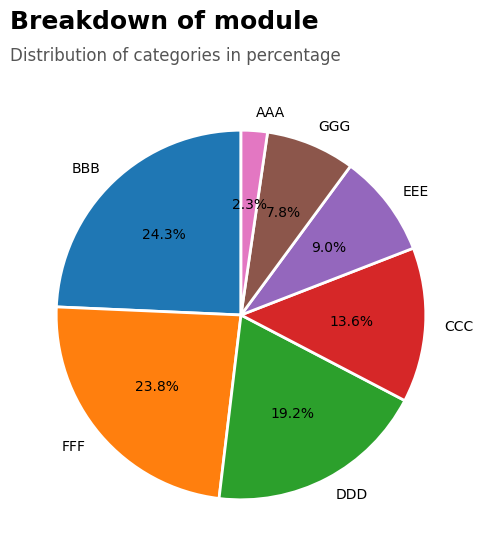

In [130]:
plt.figure(figsize=(6,6))
P.plot_pie('module',data)

- ***`BBB` and `FFF` have the most occurances***

**presentation**

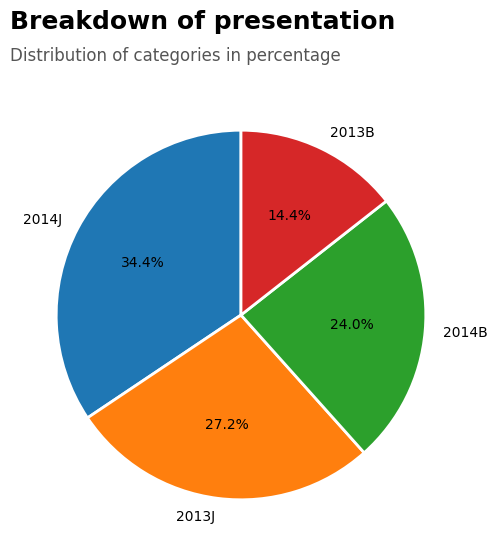

In [131]:
plt.figure(figsize=(6,6))
P.plot_pie('presentation',data)

- ***`2014J` is the most frequent value in presentation column***

**gender**

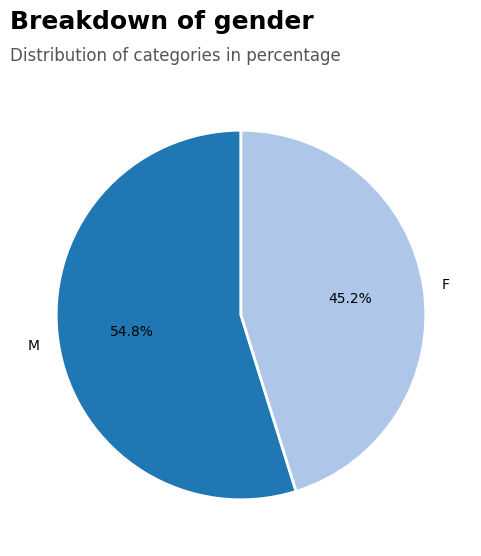

In [132]:
plt.figure(figsize=(6,6))
P.plot_pie('gender',data)

- ***`Male` gender have slighly more occurances than `female` gender***

**student_region**

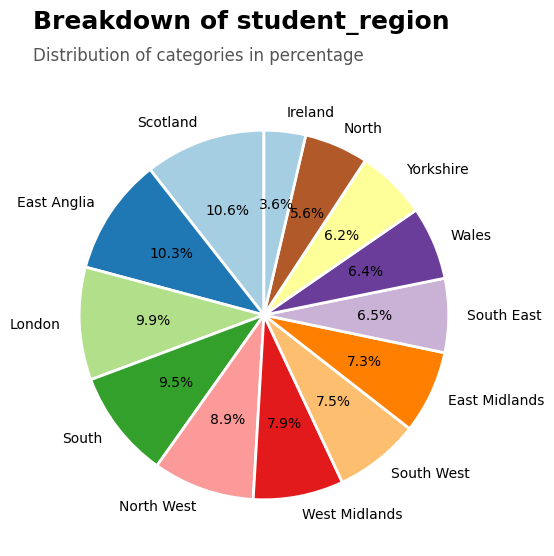

In [133]:
plt.figure(figsize=(6,6))
P.plot_pie('student_region',data)

In [134]:
data['student_region'].nunique()

13

- ***There are `13 unique values` in `student_region` column, values are nicely distributed so we are not going to reduce the classes***

**qualification**

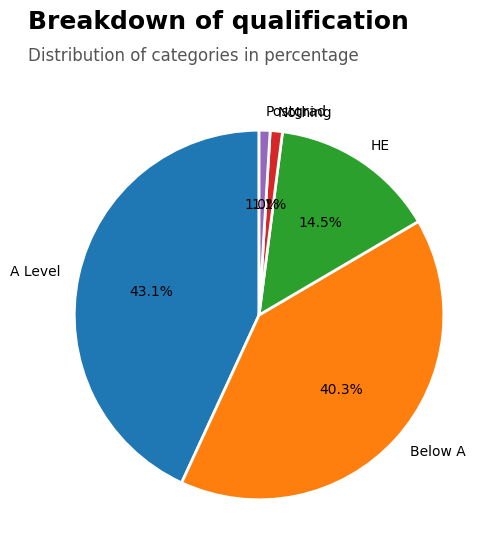

In [135]:
plt.figure(figsize=(6,6))
P.plot_pie('qualification',data)

In [136]:
data['qualification'].value_counts()

qualification
A Level     14004
Below A     13099
HE           4716
Nothing       347
Postgrad      312
Name: count, dtype: int64

- ***Classes which have low occurances, atleast have a `good sample size`, so I am keeping them***

**imd_band**

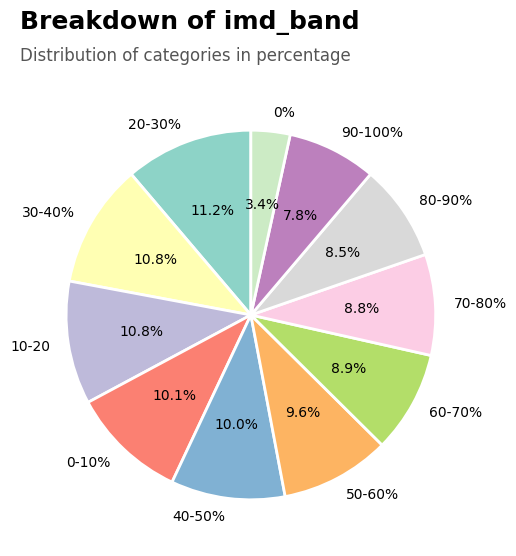

In [137]:
plt.figure(figsize=(6,6))
P.plot_pie('imd_band',data)

- ***`imd_band` is almost `equally distributed`, so I am keeping them***

**age_band**

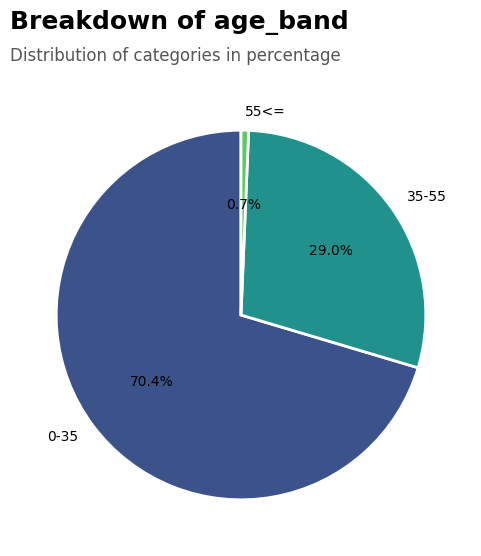

In [138]:
plt.figure(figsize=(6,6))
P.plot_pie('age_band',data)

In [139]:
data['age_band'].value_counts()

age_band
0-35     22860
35-55     9403
55<=       215
Name: count, dtype: int64

- ***Class with the lowest occurances still have good sample size, so keeping them***

**prev_attempts**

In [140]:
data['prev_attempts'].describe().round(2).reset_index()

index  prev_attempts
0  count       32478.00
1   mean           0.16
2    std           0.48
3    min           0.00
4    25%           0.00
5    50%           0.00
6    75%           0.00
7    max           6.00

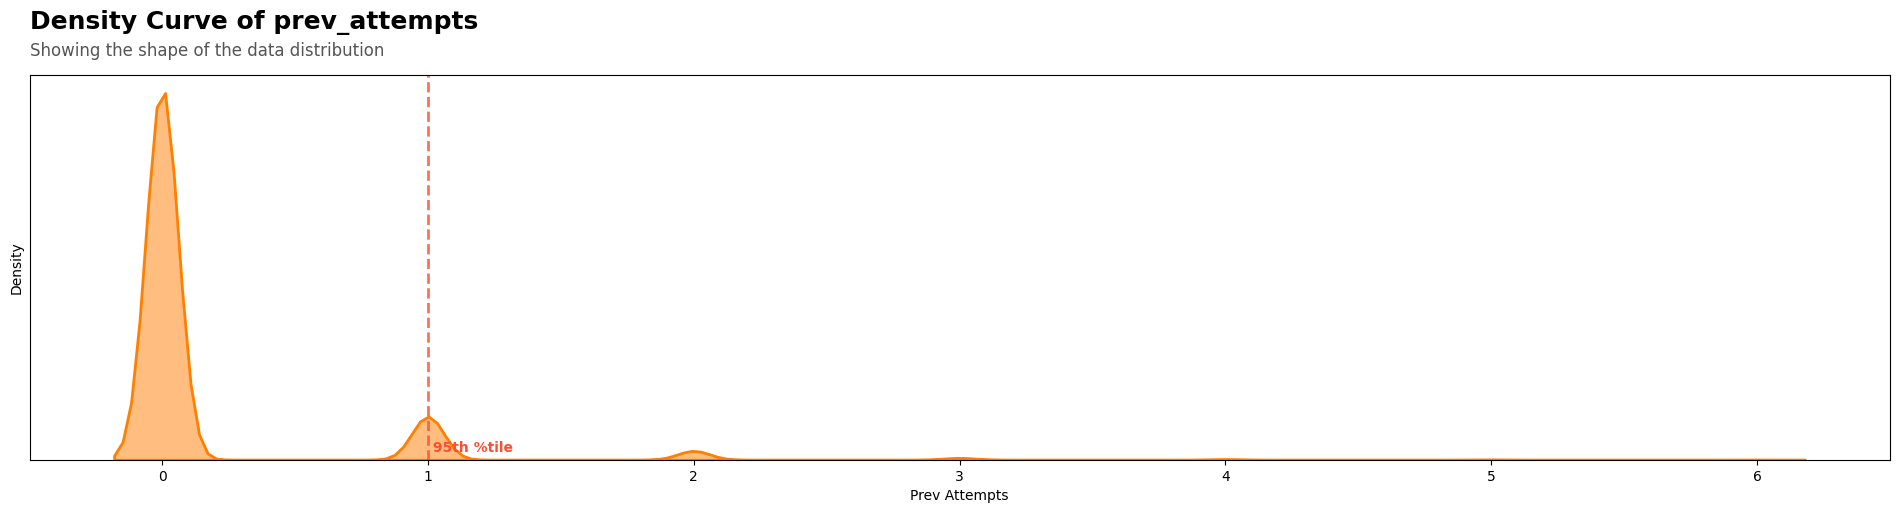

In [141]:
plt.figure(figsize=(24,5))
P.plot_kde('prev_attempts',data)

In [142]:
data['prev_attempts'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

prev_attempts  percentage
0              0       87.21
1              1       10.11
2              2        2.08
3              3        0.44
4              4        0.12
5              5        0.04
6              6        0.01

In [143]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['prev_attempts'] = pd.cut(data['prev_attempts'], bins=bins, labels=labels)

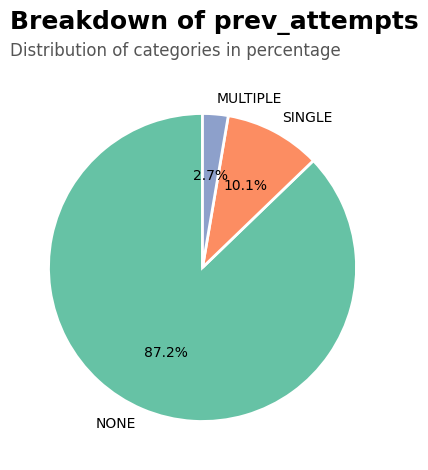

In [144]:
plt.figure(figsize=(24,5))
P.plot_pie('prev_attempts',data)

- ***Changed the type of `prev_attempts`, most of the observations are from `none` class***

**credits**

In [145]:
data['credits'].describe().round(2).reset_index()

index   credits
0  count  32478.00
1   mean     79.69
2    std     41.04
3    min     30.00
4    25%     60.00
5    50%     60.00
6    75%    120.00
7    max    655.00

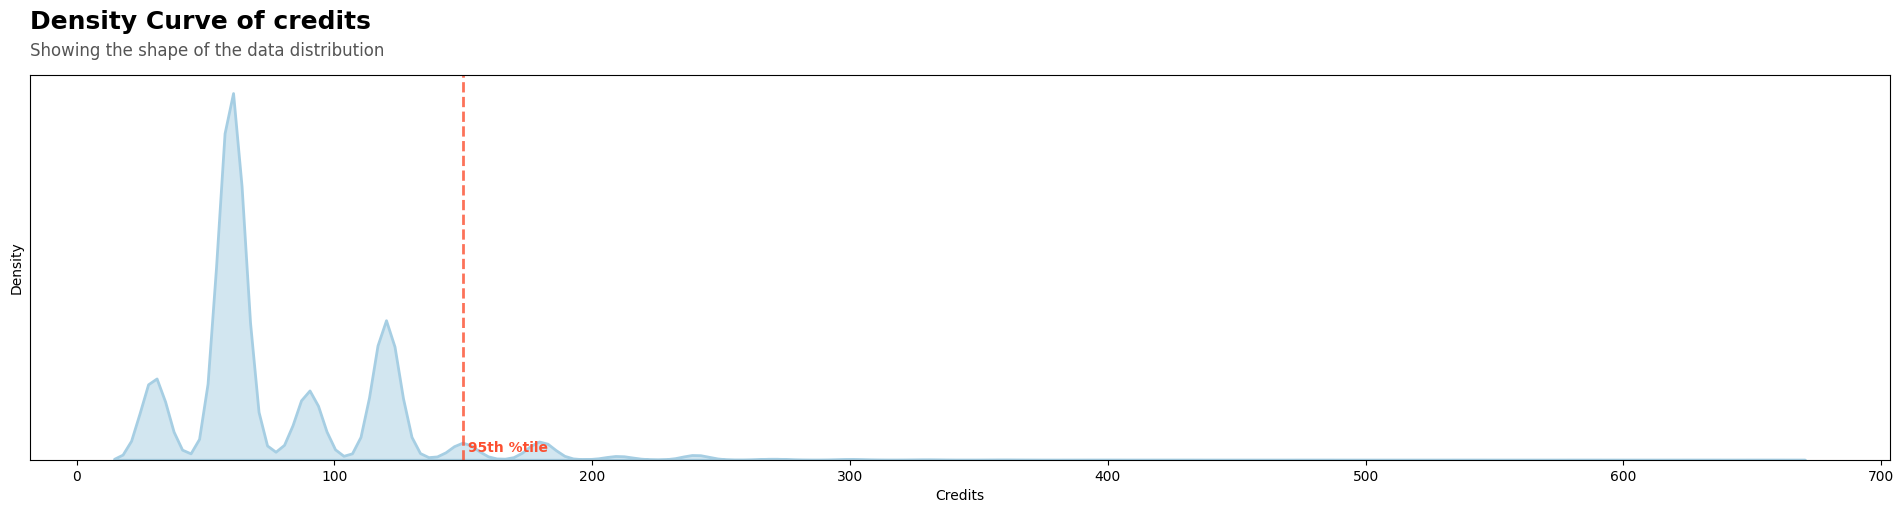

In [146]:
plt.figure(figsize=(24,5))
P.plot_kde('credits',data)

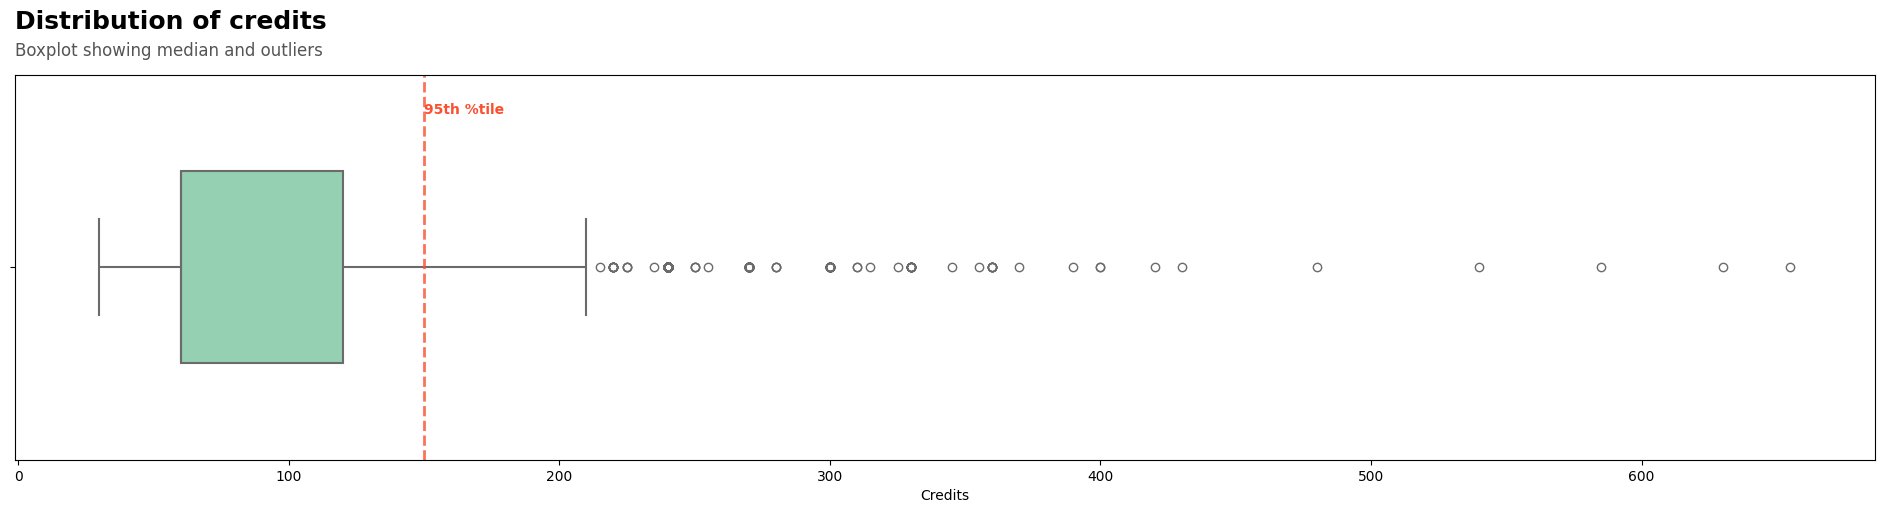

In [147]:
plt.figure(figsize=(24,5))
P.plot_box('credits',data)

In [148]:
data['credits'].skew().round(2)

np.float64(1.88)

- ***There are outliers in credits column, and values are skewed towards right***

**disability**

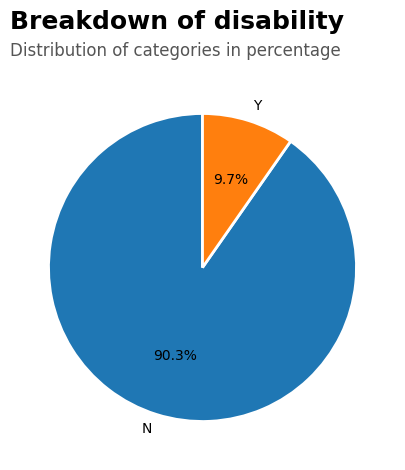

In [149]:
plt.figure(figsize=(24,5))
P.plot_pie('disability',data)

- ***most of the values in `disability` column is `N` - approx `91%`***

**registration**

In [150]:
data['registration'].describe().round(2).reset_index()

index  registration
0  count      32478.00
1   mean        -69.41
2    std         49.25
3    min       -322.00
4    25%       -100.00
5    50%        -57.00
6    75%        -29.00
7    max        167.00

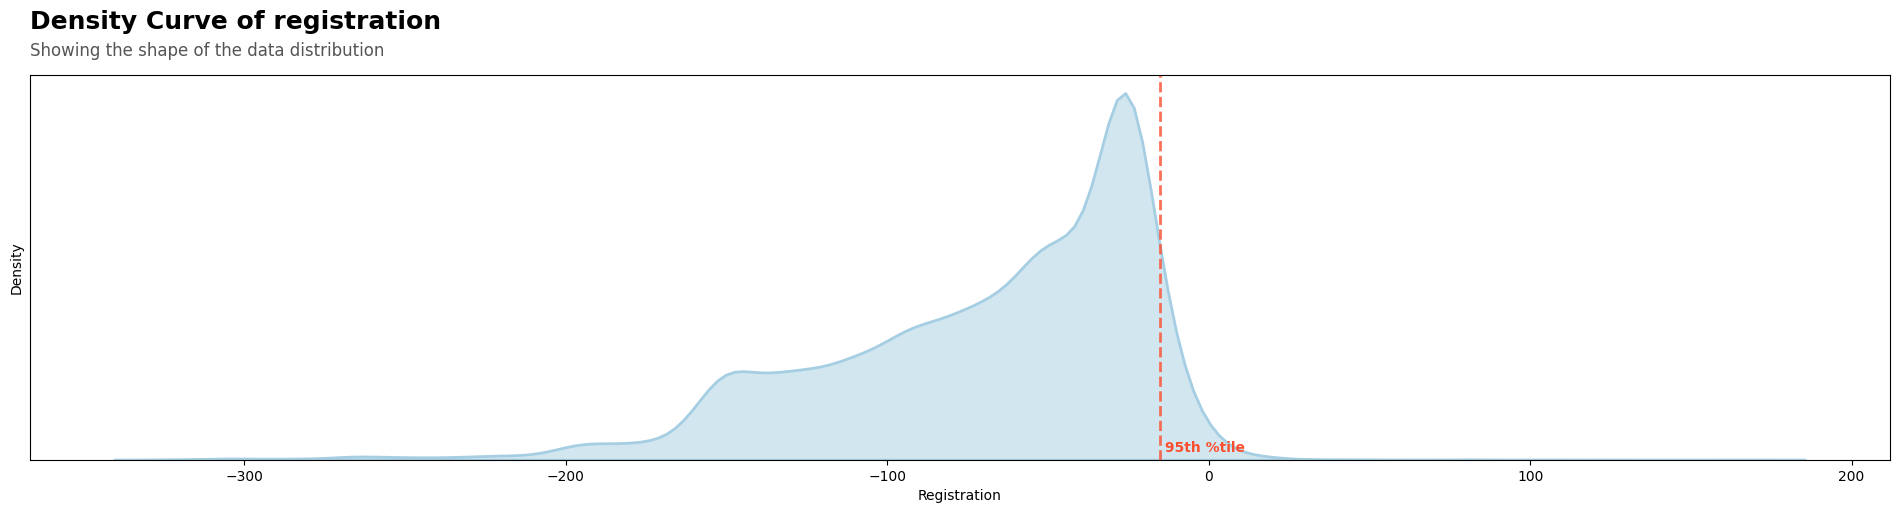

In [151]:
plt.figure(figsize=(24,5))
P.plot_kde('registration',data)

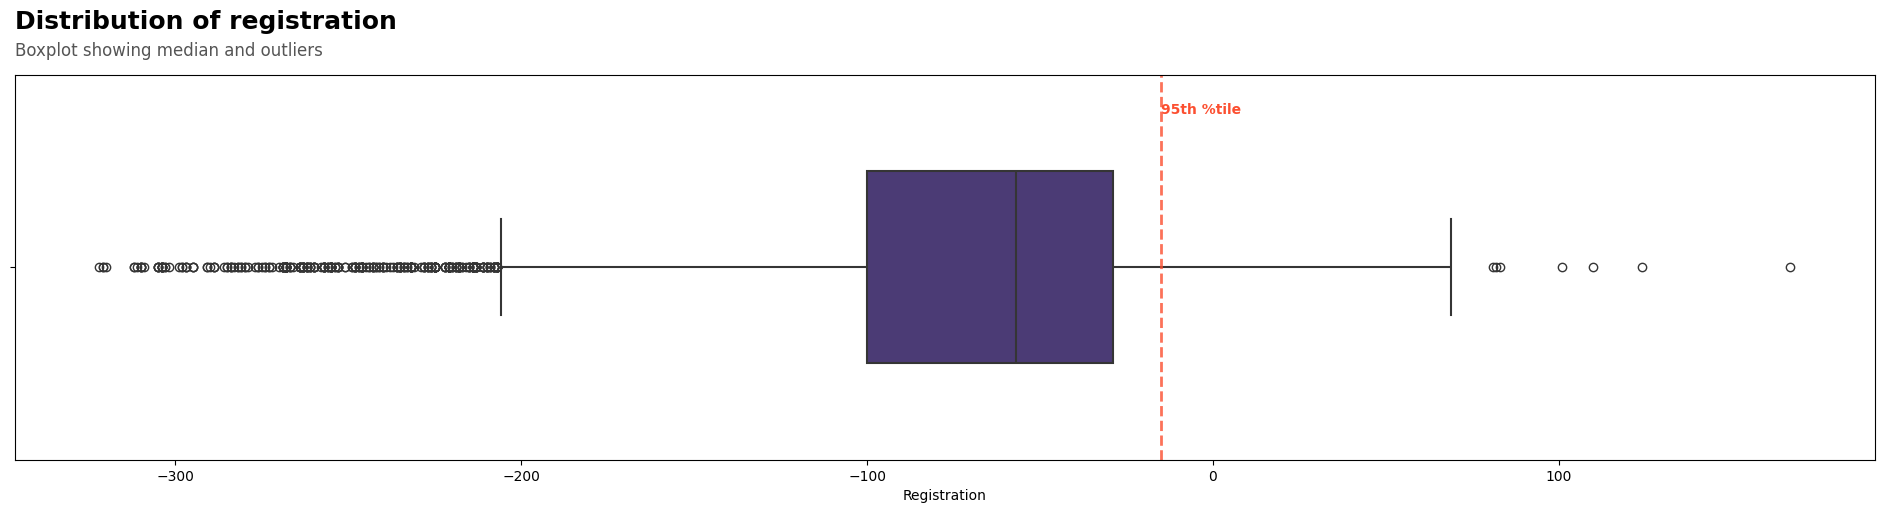

In [152]:
plt.figure(figsize=(24,5))
P.plot_box('registration',data)

In [153]:
data['registration'].skew().round(2)

np.float64(-1.01)

- ***registration column have a little skewness over to the lest, and more outliers to the smaller end***

**unregistration**

In [154]:
data['unregistration'].describe().round(2).reset_index()

index  unregistration
0  count        10041.00
1   mean           50.20
2    std           82.03
3    min         -317.00
4    25%           -1.00
5    50%           28.00
6    75%          109.00
7    max          444.00

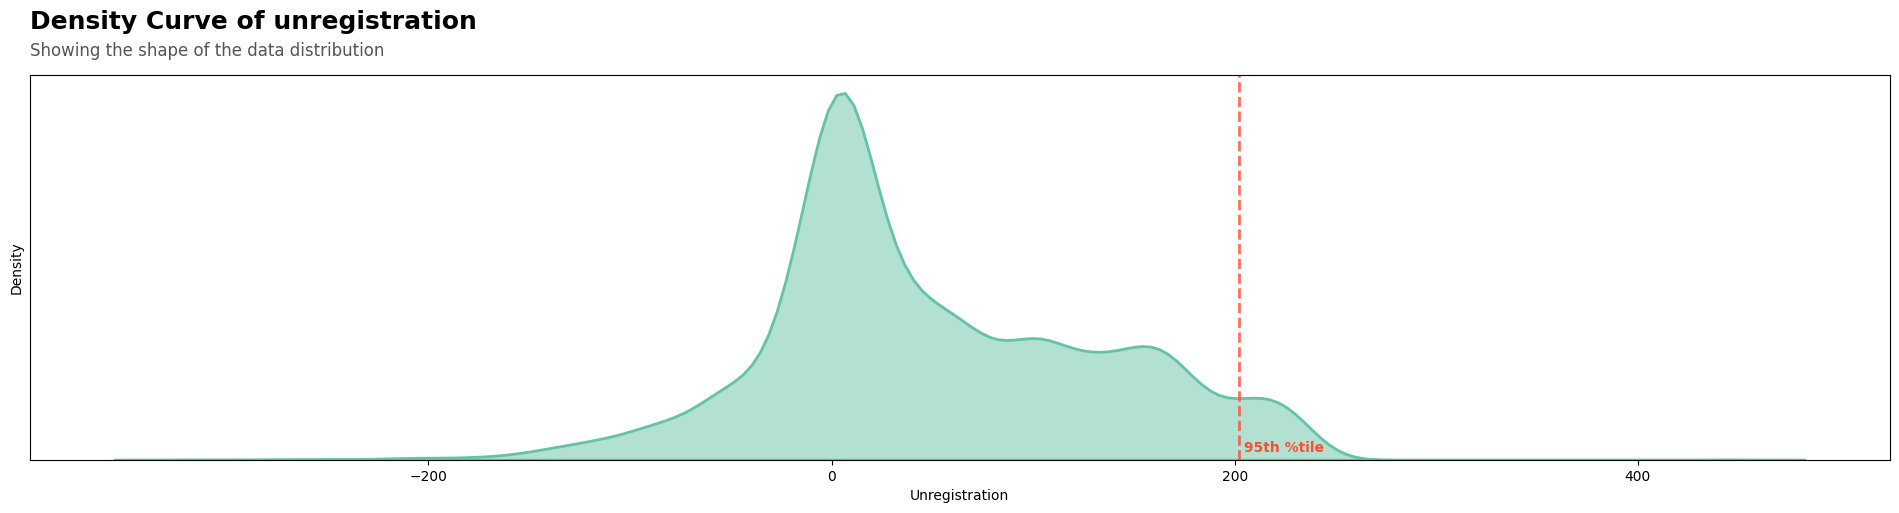

In [155]:
plt.figure(figsize=(24,5))
P.plot_kde('unregistration',data)

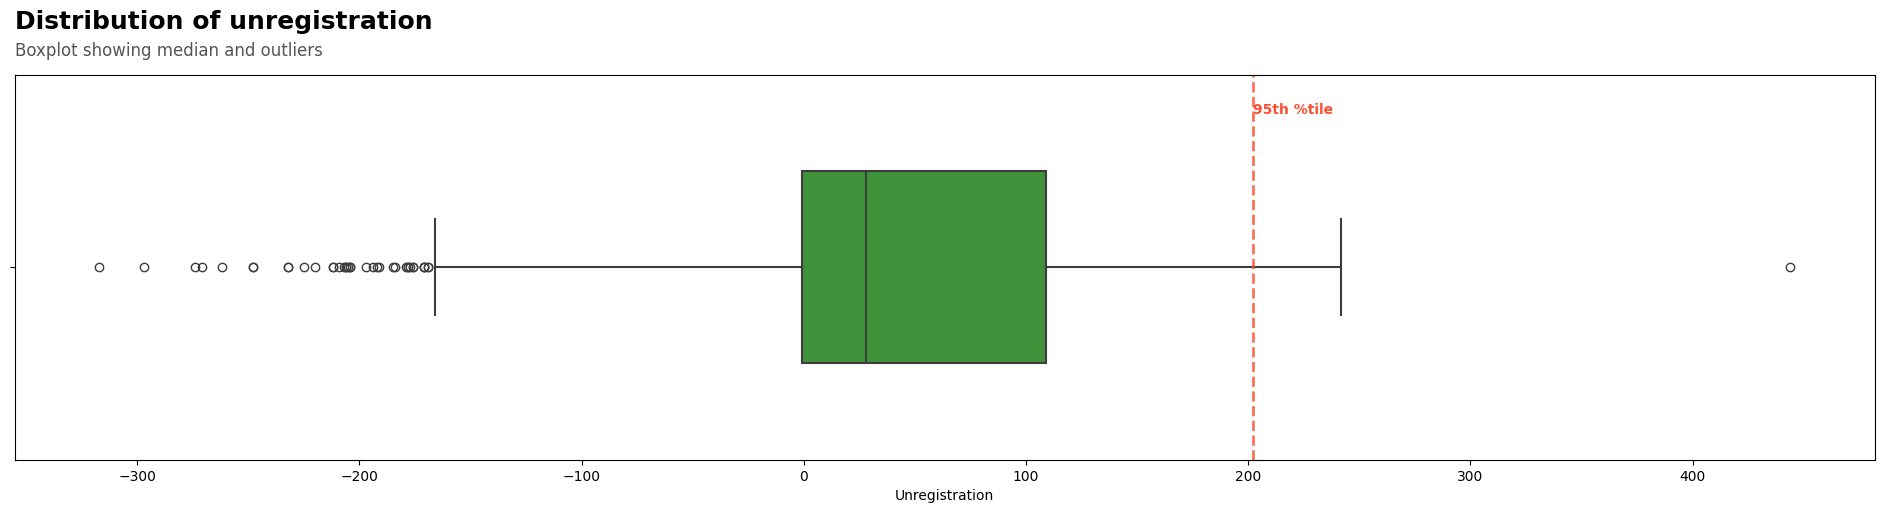

In [156]:
plt.figure(figsize=(24,5))
P.plot_box('unregistration',data)

In [157]:
data['unregistration'].skew().round(2)

np.float64(0.27)

- ***unregistration column have skew towards left, and more outliers to the smaller end***

**vle_used**

In [158]:
data['vle_used'].describe().round(2).reset_index()

index  vle_used
0  count  32478.00
1   mean     60.31
2    std     55.92
3    min      0.00
4    25%     19.00
5    50%     46.00
6    75%     86.00
7    max    413.00

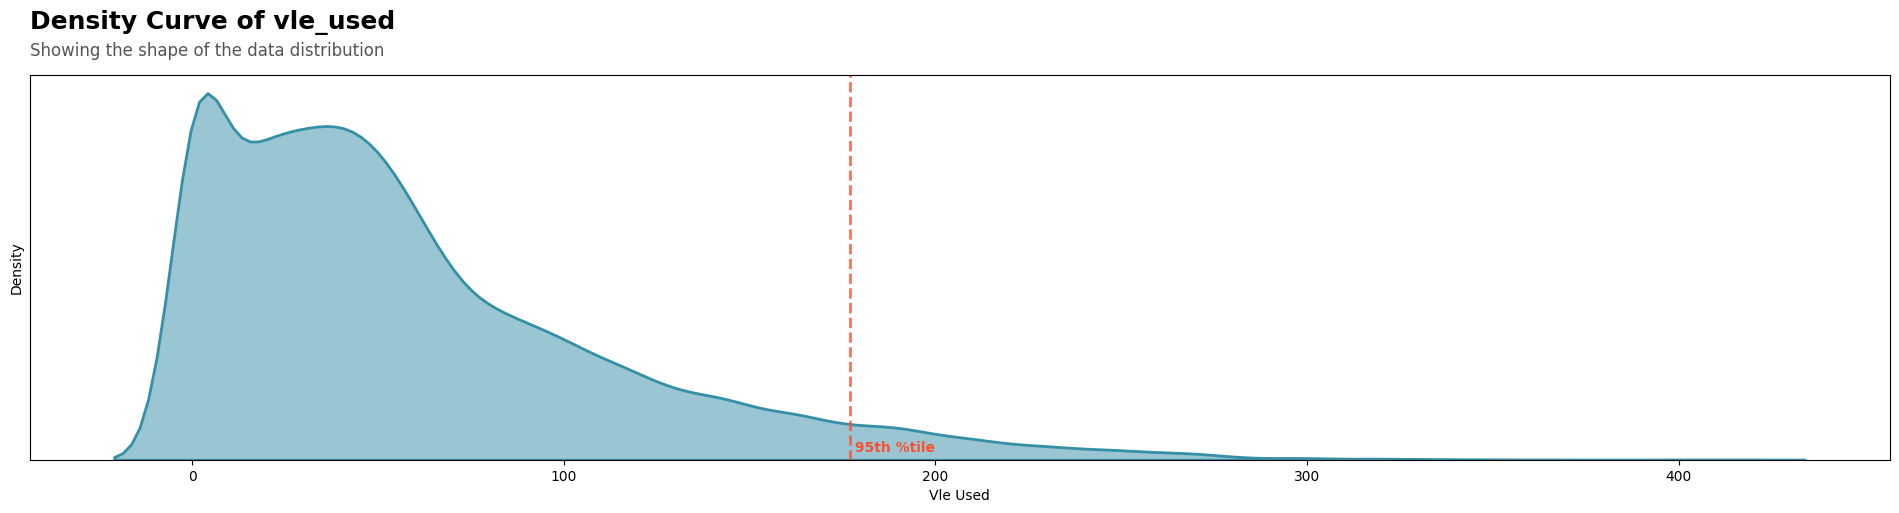

In [159]:
plt.figure(figsize=(24,5))
P.plot_kde('vle_used',data)

In [160]:
data['vle_used'].skew().round(2)

np.float64(1.37)

- ***vle_used have skewness towards right***

**clicks**

In [161]:
data['clicks'].describe().round(2).reset_index()

index    clicks
0  count  32478.00
1   mean   1218.85
2    std   1694.35
3    min      0.00
4    25%    145.00
5    50%    605.00
6    75%   1591.00
7    max  24139.00

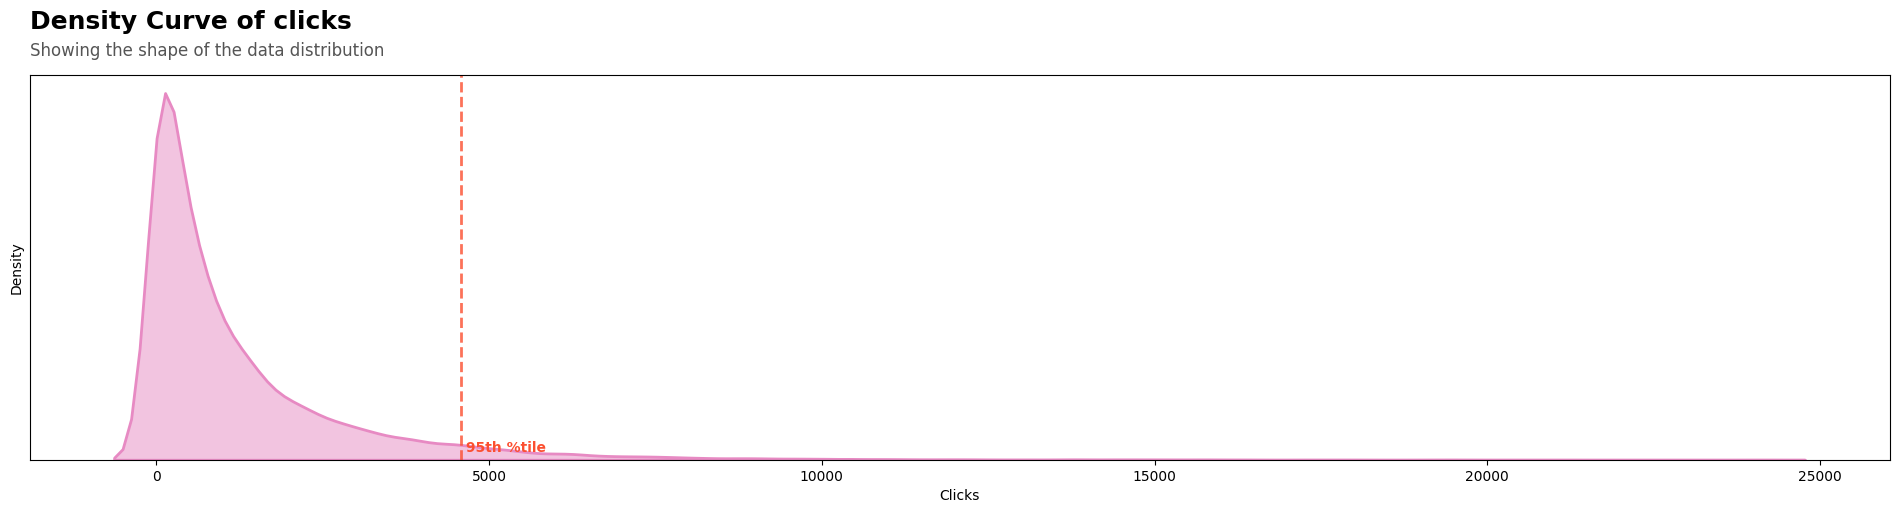

In [162]:
plt.figure(figsize=(24,5))
P.plot_kde('clicks',data)

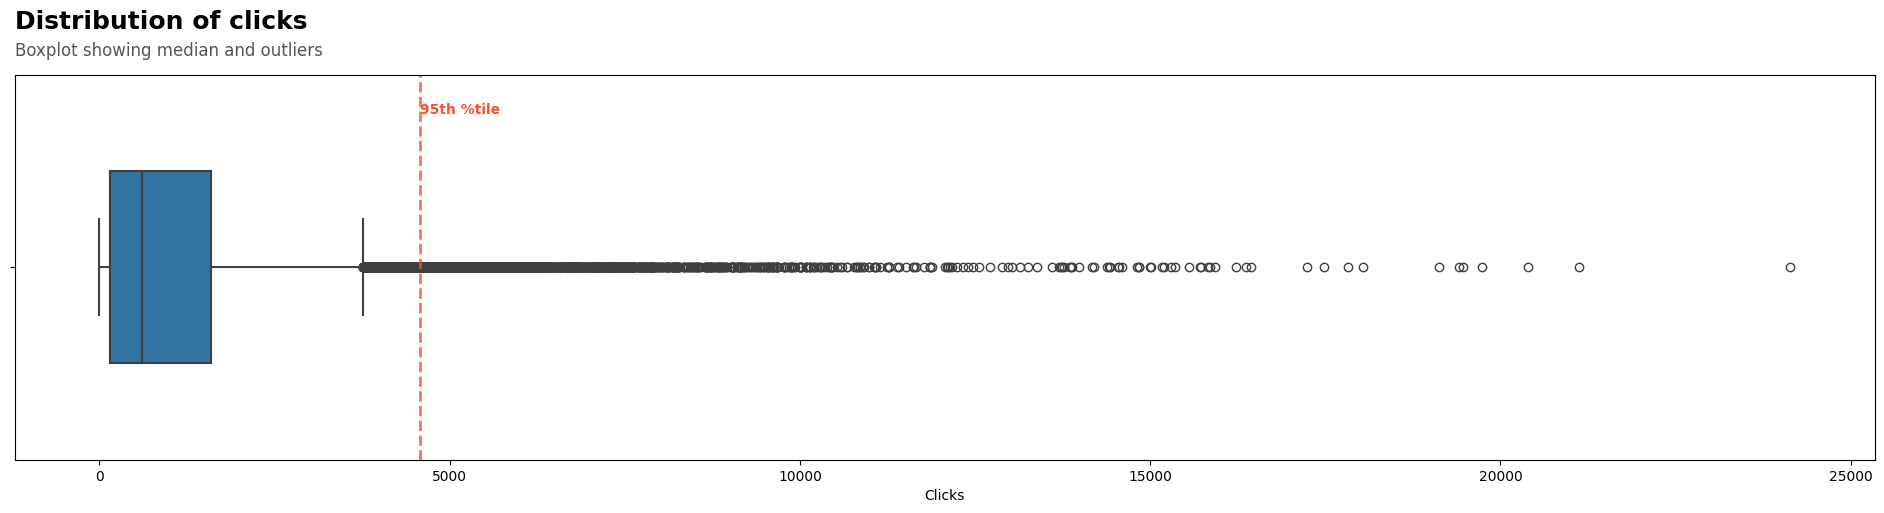

In [163]:
plt.figure(figsize=(24,5))
P.plot_box('clicks',data)

In [164]:
data['clicks'].skew().round(2)

np.float64(3.02)

- ***clicks is skewed towards right, and outliers to the higher end***

**assessments**

In [165]:
data['assessments'].describe().round(2).reset_index()

index  assessments
0  count     32478.00
1   mean         5.35
2    std         4.32
3    min         0.00
4    25%         1.00
5    50%         5.00
6    75%         9.00
7    max        14.00

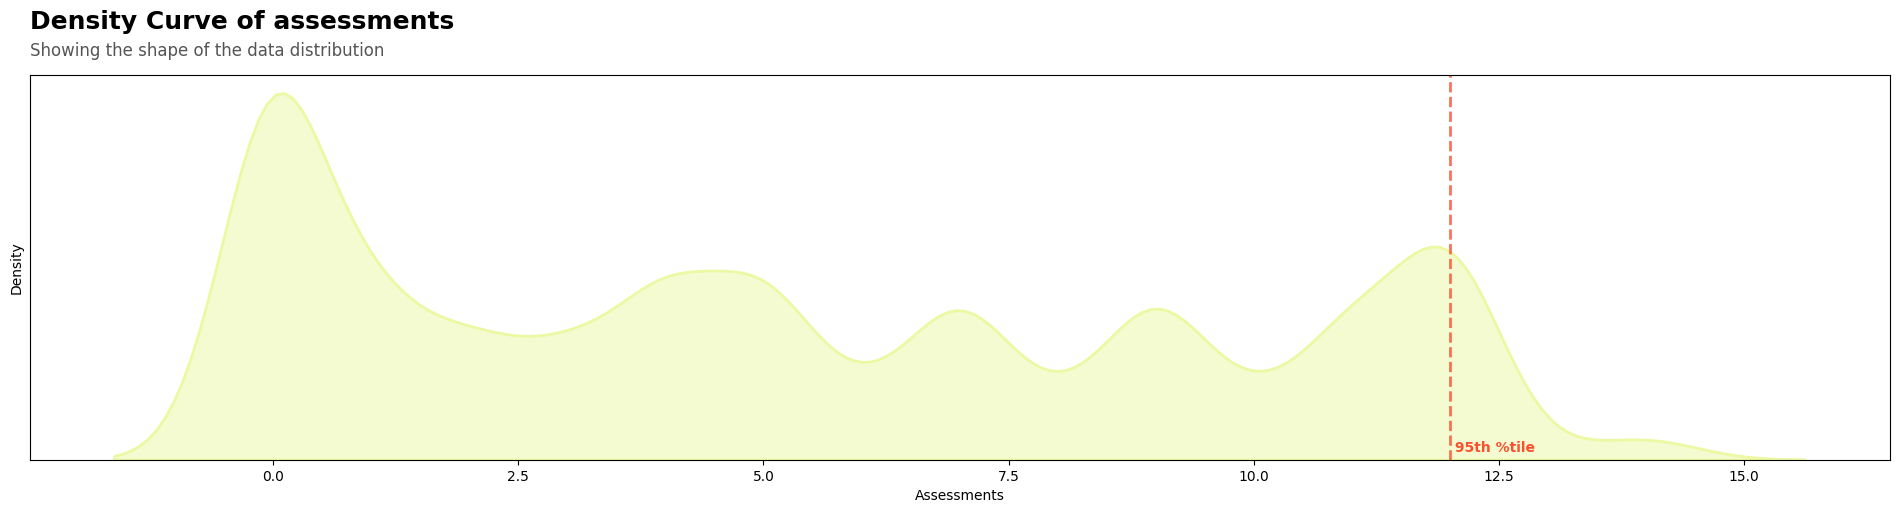

In [166]:
plt.figure(figsize=(24,5))
P.plot_kde('assessments',data)

**attempted_assessment**

In [167]:
data['attempted_assessment'].describe().round(2).reset_index()

index  attempted_assessment
0  count              32478.00
1   mean                  5.29
2    std                  4.34
3    min                  0.00
4    25%                  1.00
5    50%                  5.00
6    75%                  9.00
7    max                 14.00

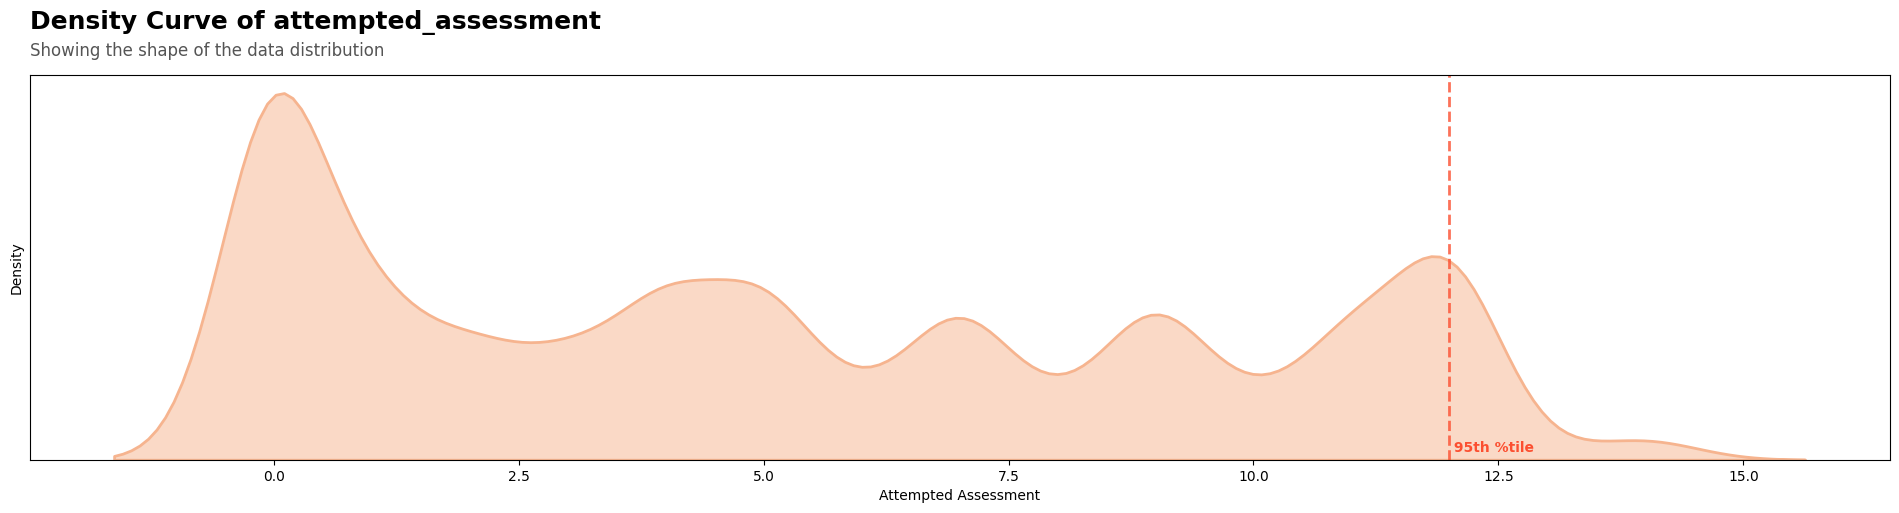

In [168]:
plt.figure(figsize=(24,5))
P.plot_kde('attempted_assessment',data)

**non_attempted_assessment**

In [169]:
data['non_attempted_assessment'].describe().round(2).reset_index()

index  non_attempted_assessment
0  count                  32478.00
1   mean                      0.06
2    std                      0.53
3    min                      0.00
4    25%                      0.00
5    50%                      0.00
6    75%                      0.00
7    max                     12.00

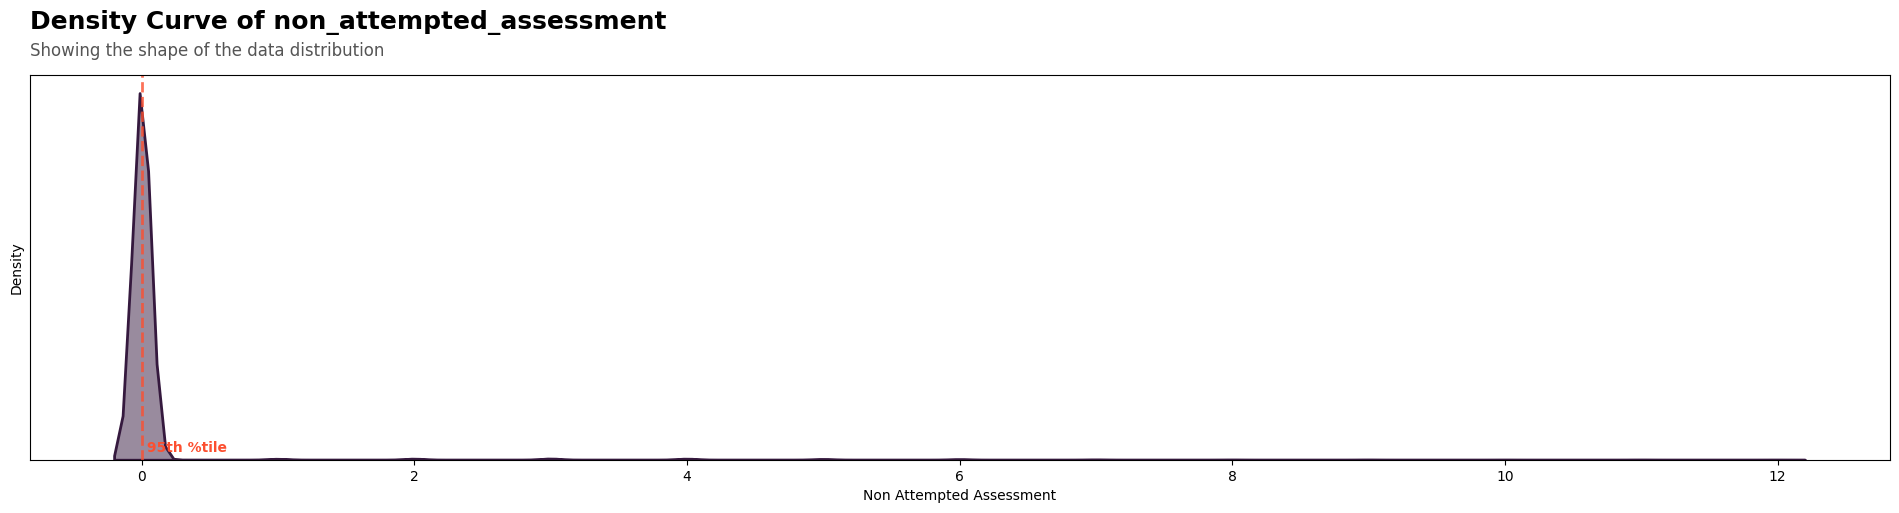

In [170]:
plt.figure(figsize=(24,5))
P.plot_kde('non_attempted_assessment',data)

In [171]:
data['non_attempted_assessment'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

non_attempted_assessment  percentage
0                          0       98.39
1                          3        0.33
2                          2        0.29
3                          4        0.29
4                          1        0.26
5                          5        0.17
6                          6        0.14
7                          7        0.05
8                          9        0.02
9                          8        0.02
10                        11        0.02
11                        10        0.01
12                        12        0.01

In [172]:
bins = [-1, 0, 100]
labels = ['NONE', 'ANY']
data['non_attempted_assessment'] = pd.cut(data['non_attempted_assessment'], bins=bins, labels=labels)

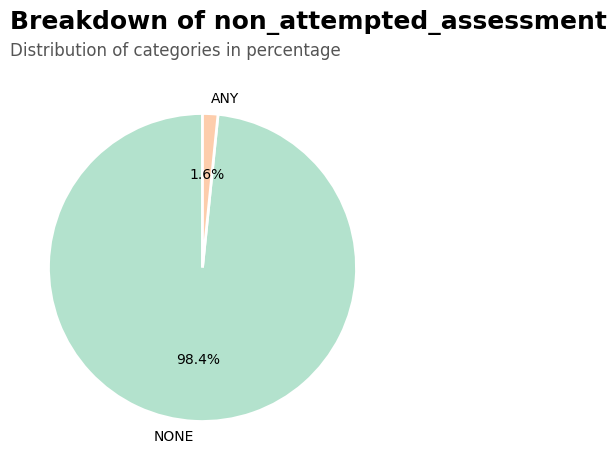

In [173]:
plt.figure(figsize=(24,5))
P.plot_pie('non_attempted_assessment',data)

**score**

In [174]:
data['score'].describe().round(2).reset_index()

index     score
0  count  32478.00
1   mean     57.81
2    std     32.84
3    min      0.00
4    25%     43.50
5    50%     70.67
6    75%     82.43
7    max    100.00

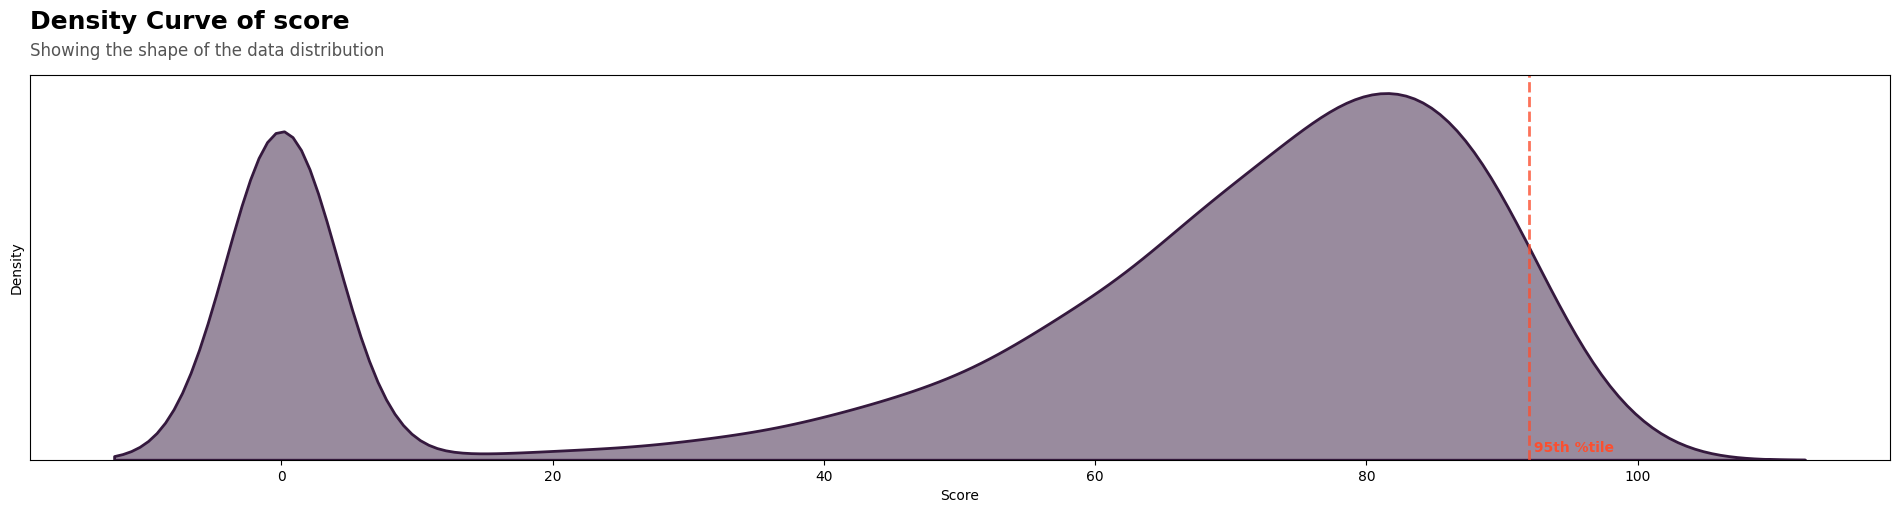

In [175]:
plt.figure(figsize=(24,5))
P.plot_kde('score',data)

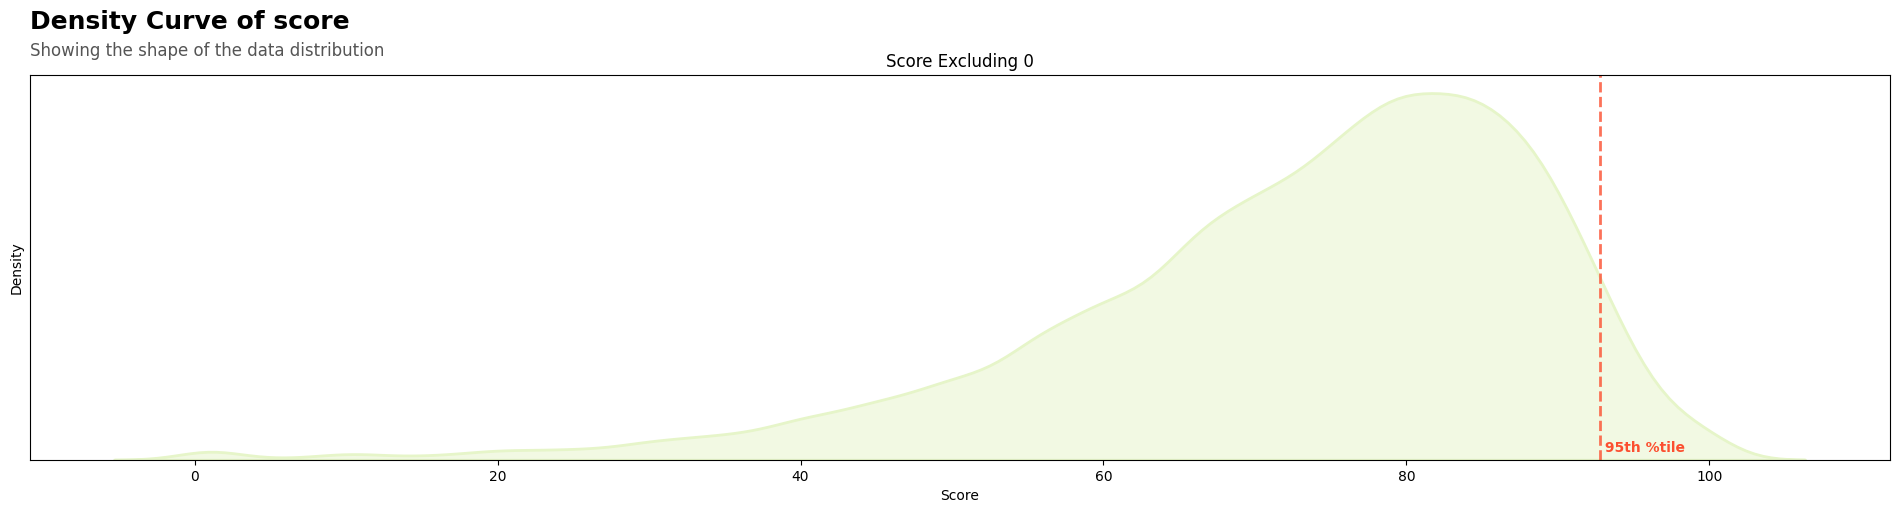

In [176]:
plt.figure(figsize=(24,5))
P.plot_kde('score',data[data['score'] != 0])
plt.title('Score Excluding 0')
plt.show()

**clicks_per_vle**

In [177]:
data['clicks_per_vle'].describe().round(2).reset_index()

index  clicks_per_vle
0  count        32478.00
1   mean           15.21
2    std           14.79
3    min            0.00
4    25%            6.12
5    50%           12.02
6    75%           20.48
7    max          314.00

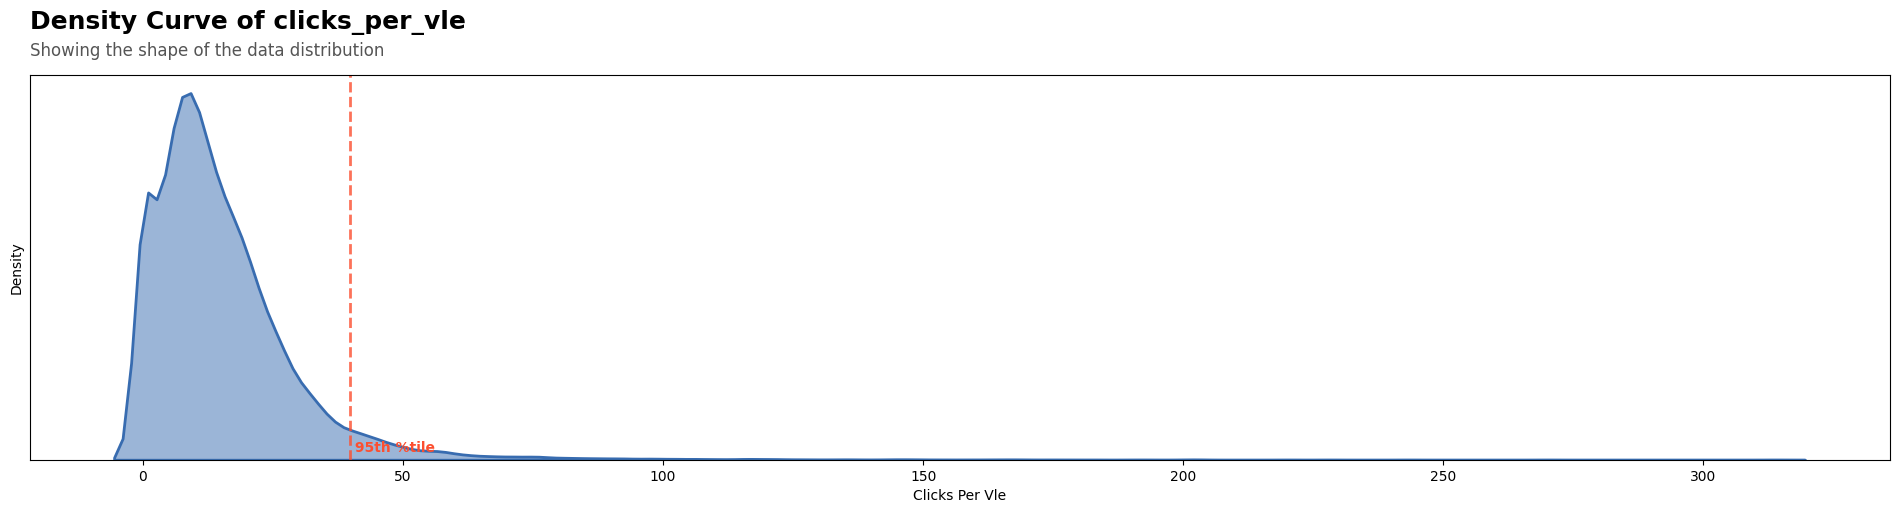

In [178]:
plt.figure(figsize=(24,5))
P.plot_kde('clicks_per_vle',data)

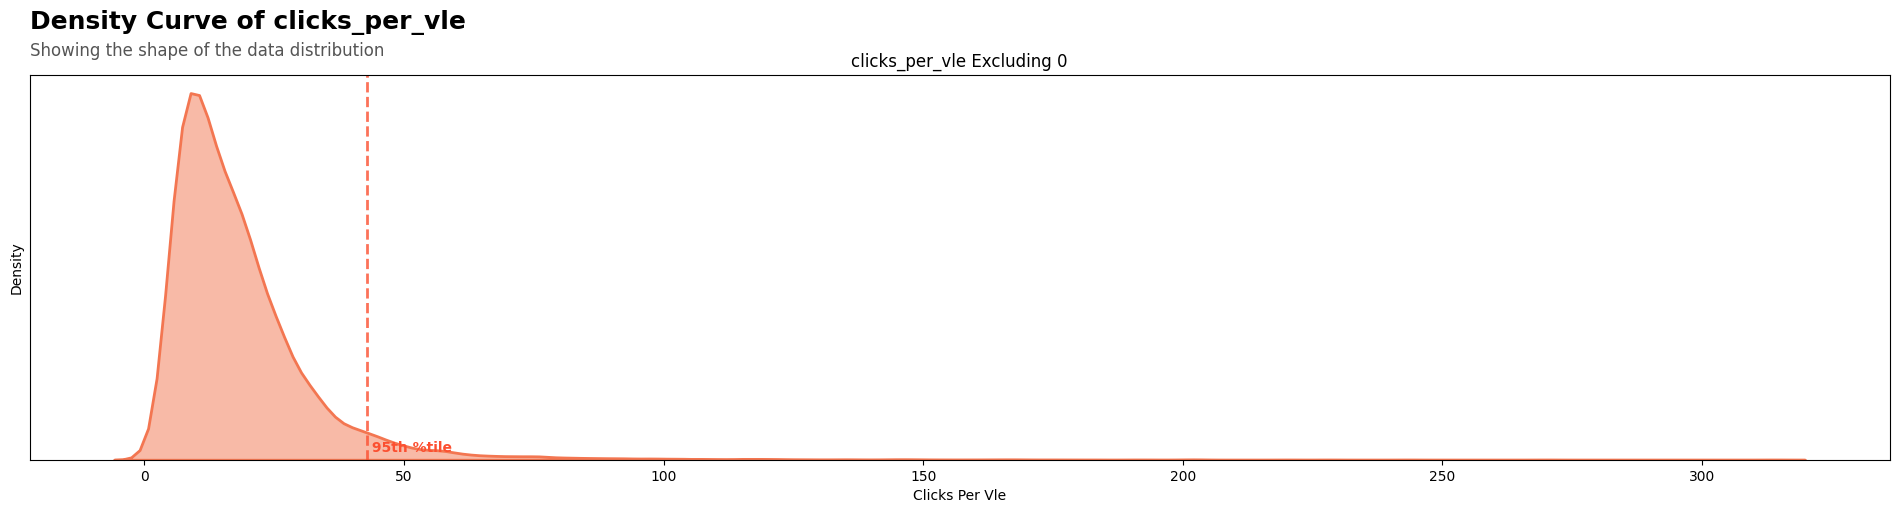

In [179]:
plt.figure(figsize=(24,5))
P.plot_kde('clicks_per_vle',data[data['score'] != 0])
plt.title('clicks_per_vle Excluding 0')
plt.show()

**attempt_pct**

In [180]:
data['attempt_pct'].describe().round(2).reset_index()

index  attempt_pct
0  count     32478.00
1   mean        78.30
2    std        41.03
3    min         0.00
4    25%       100.00
5    50%       100.00
6    75%       100.00
7    max       100.00

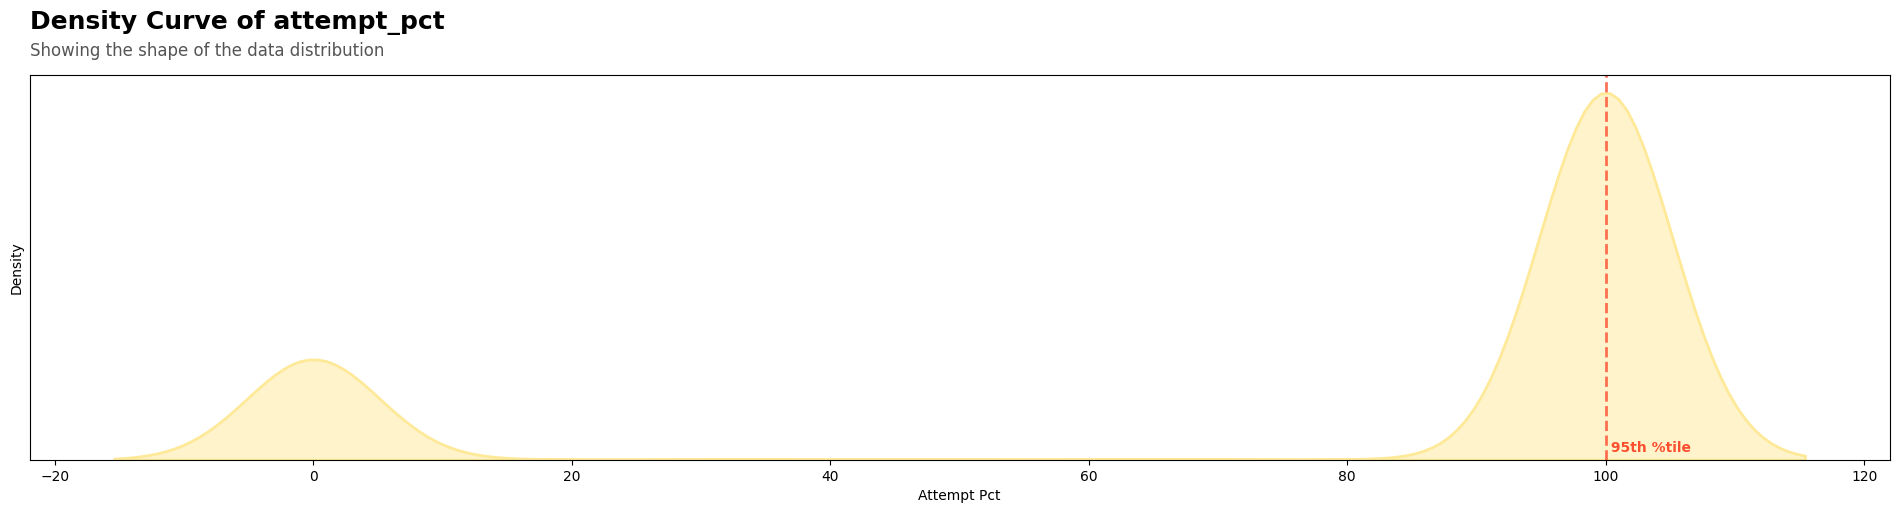

In [181]:
plt.figure(figsize=(24,5))
P.plot_kde('attempt_pct',data)

In [182]:
data['attempt_pct'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

attempt_pct  percentage
0        100.00       77.88
1          0.00       21.31
2         66.67        0.10
3         33.33        0.08
4         50.00        0.08
5         14.29        0.04
6         75.00        0.03
7         28.57        0.03
8         42.86        0.03
9         16.67        0.03
10        60.00        0.03
11        20.00        0.02
12        25.00        0.02
13        80.00        0.02
14        57.14        0.02
15        85.71        0.02
16        63.64        0.02
17        83.33        0.02
18        40.00        0.02
19        90.91        0.02
20        45.45        0.02
21        81.82        0.02
22        71.43        0.01
23        36.36        0.01
24        30.00        0.01
25        88.89        0.01
26        58.33        0.01
27        72.73        0.01
28        22.22        0.01
29        54.55        0.01
30        37.50        0.01
31        12.50        0.01
32        41.67        0.01
33        84.62        0.01
34        62.50        0.01
35        18.18        0.01
36        87.50        0.00
37        90.00        0.00
38        70.00        0.00
39         9.09        0.00
40        10.00        0.00
41        77.78        0.00
42        78.57        0.00
43        11.11        0.00
44        44.44        0.00
45        91.67        0.00

In [183]:
bins = [-1, 99, 100]
labels = ['NONE', 'ALL']
data['attempt_pct'] = pd.cut(data['attempt_pct'], bins=bins, labels=labels)

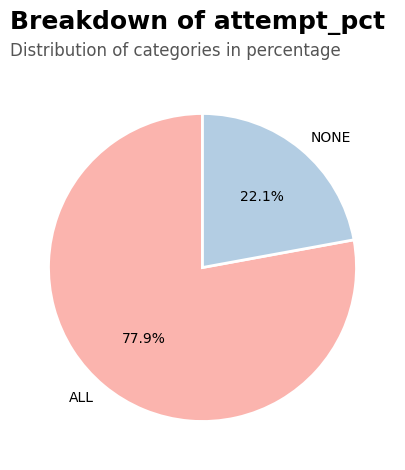

In [184]:
plt.figure(figsize=(24,5))
P.plot_pie('attempt_pct',data)

**final_result**

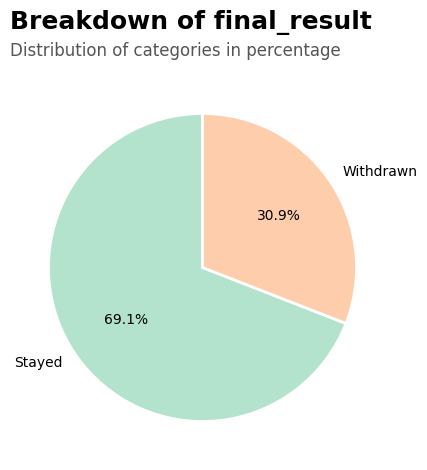

In [185]:
plt.figure(figsize=(24,5))
P.plot_pie('final_result',data)

### **Bivariate Analysis with `final_result` column**

In [186]:
cat_cols = data.select_dtypes(include='object').columns.values.tolist()

In [187]:
num_cols = data.select_dtypes(include='number').columns.values.tolist()

***CATEGORICAL COLUMNS WITH `final_result` COLUMN***

**module**

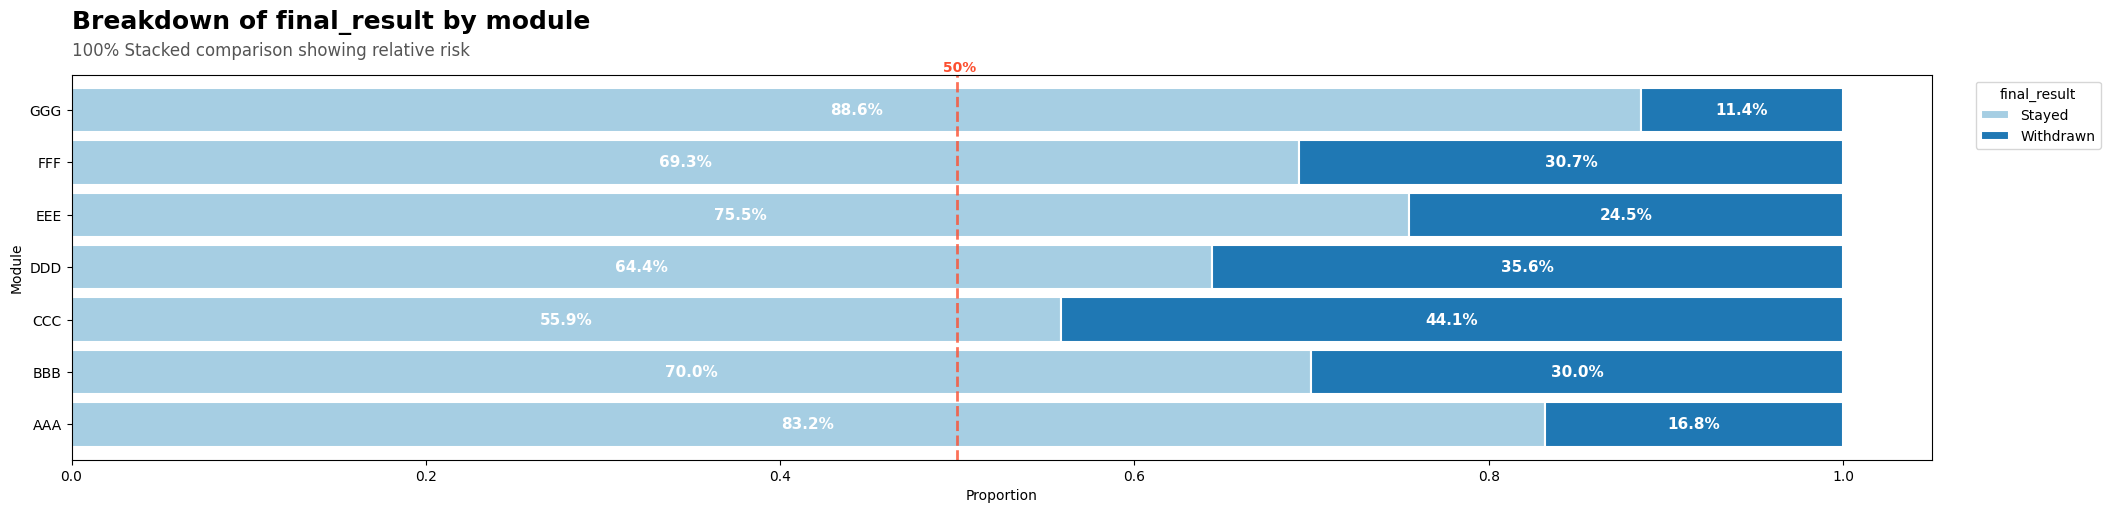

In [188]:
ct = pd.crosstab(data['module'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

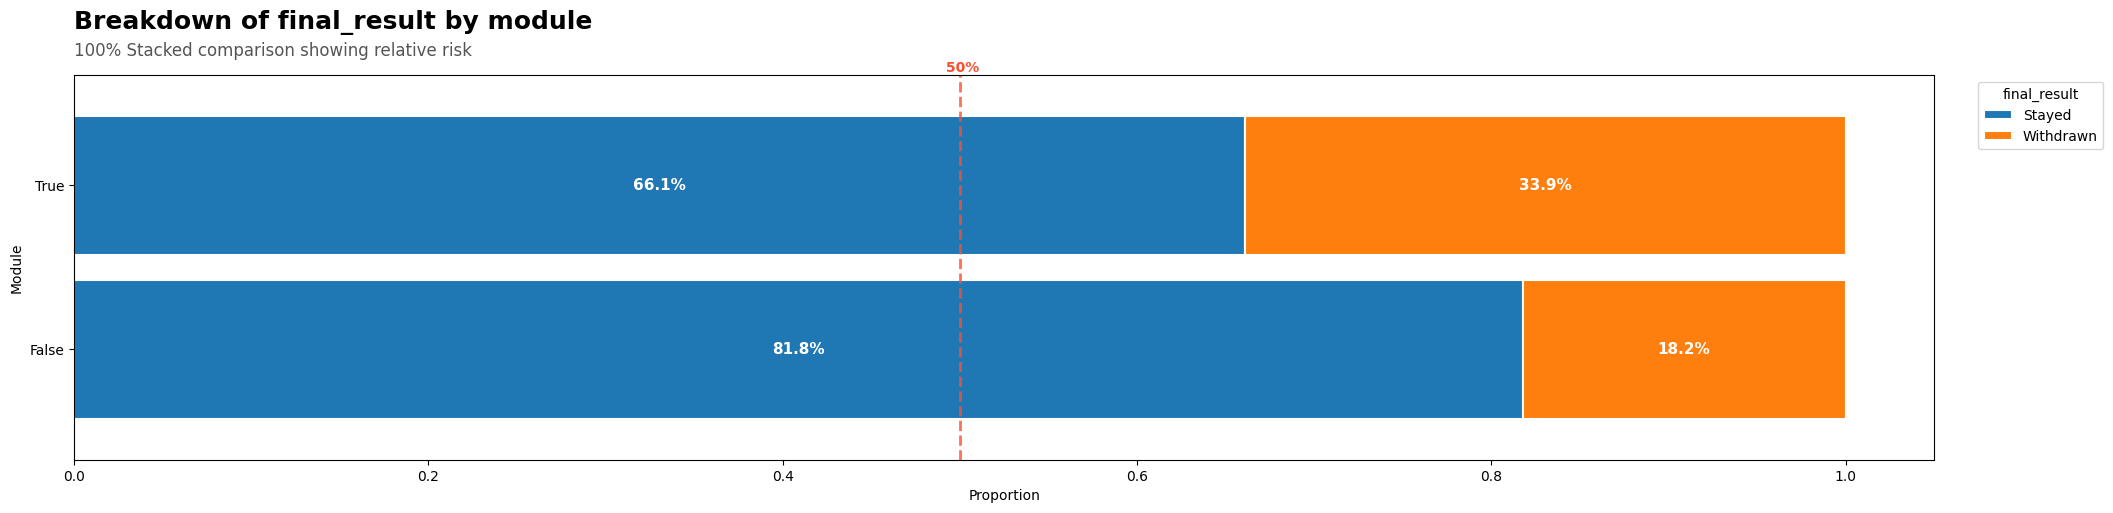

In [189]:
module_mask = (data['module']=='CCC') | (data['module']=='DDD') | (data['module']=='BBB')|(data['module']=='FFF')
ct = pd.crosstab(module_mask,data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

In [190]:
ct = pd.crosstab(module_mask,data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.133 (Moderate)


***
- ***by visuals we saw that `module BBB,CCC,DDD,FFF have more withdrawn candidates`, after doing statistical test, we can validate this assumption with `moderate strength`***
***

**presentation**

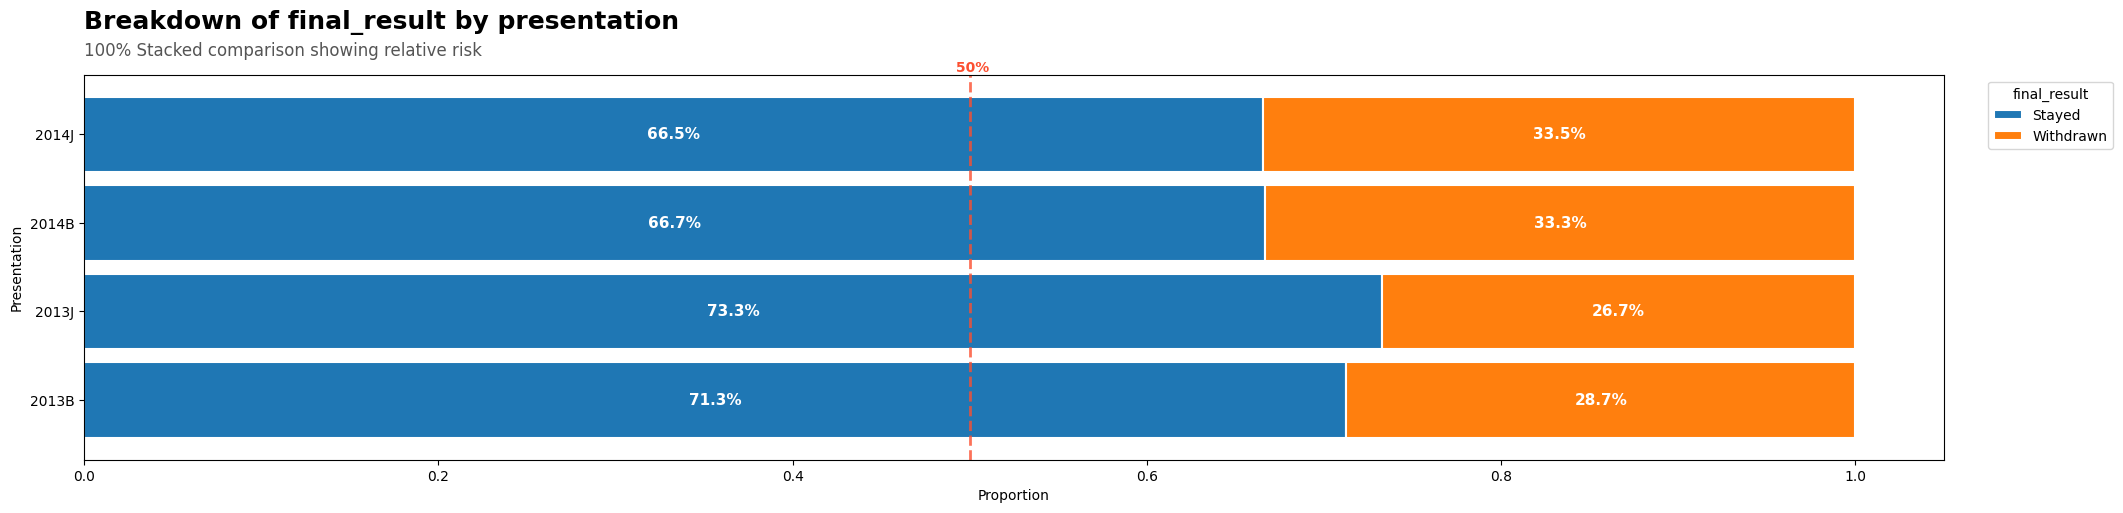

In [191]:
ct = pd.crosstab(data['presentation'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

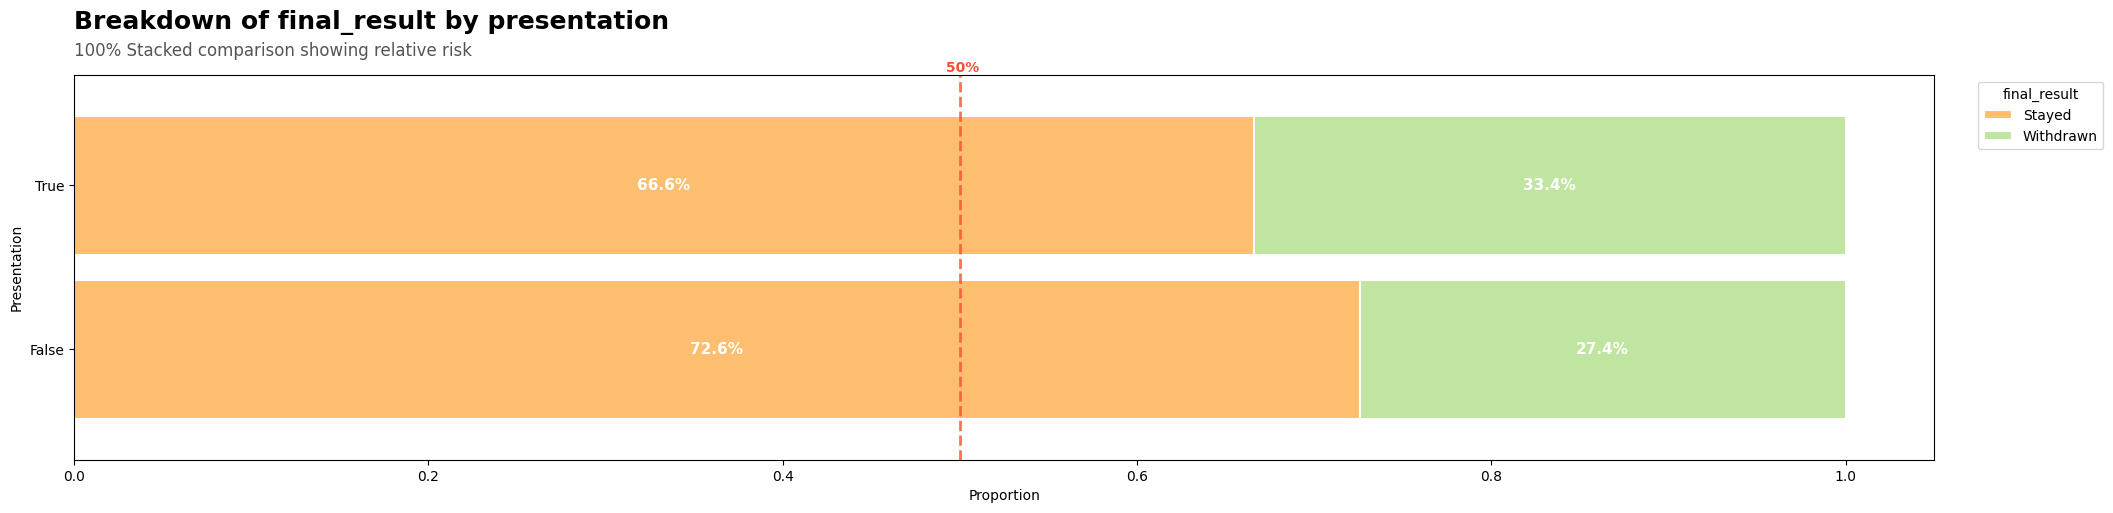

In [192]:
presentation_mask = (data['presentation']=='2014J') | (data['presentation']=='2014B')
ct = pd.crosstab(presentation_mask,data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

In [193]:
ct = pd.crosstab(presentation_mask,data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.064 (Weak)



- ***by visuals we saw that 2014B and 2014J have slighly more in final result = withdrawn, after doing statistical test, we get a weak relationship***

**gender**

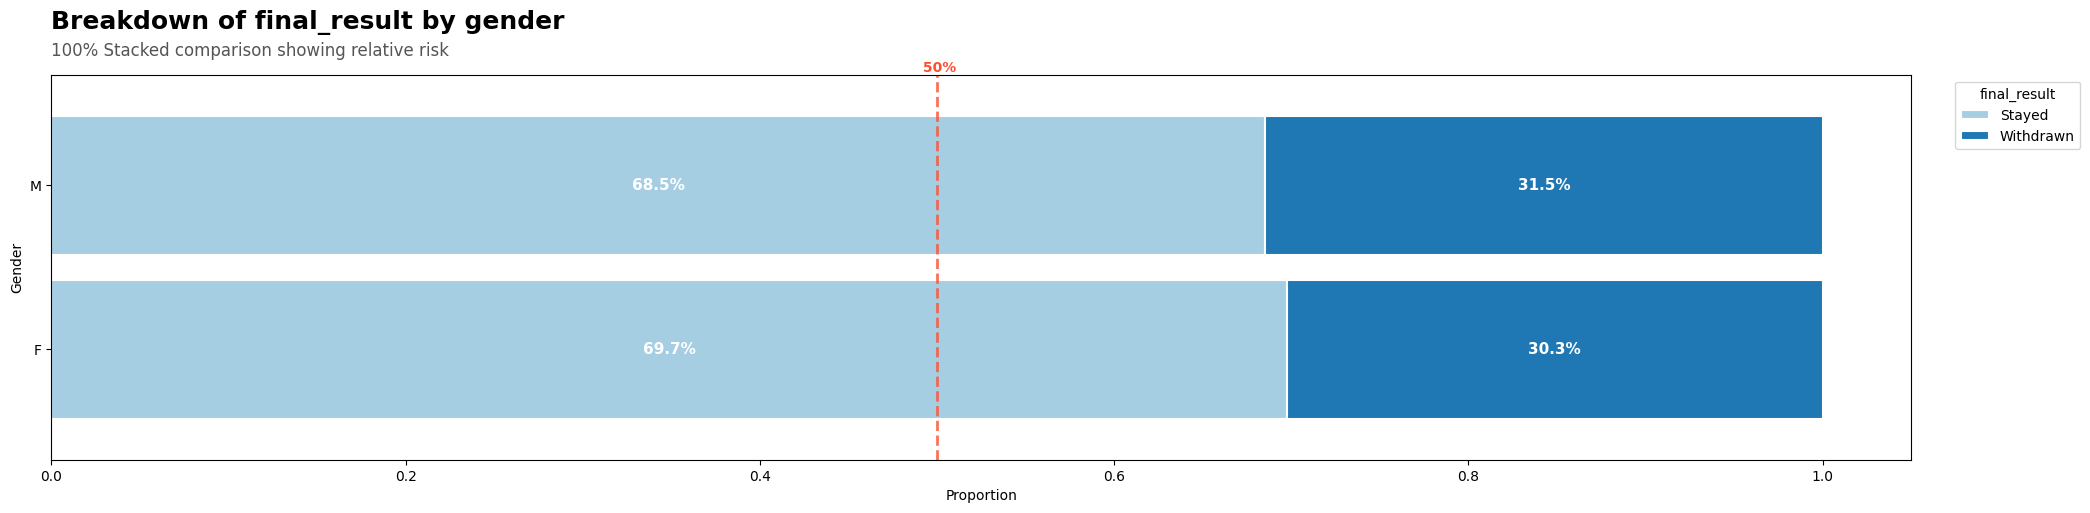

In [194]:
ct = pd.crosstab(data['gender'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

- ***by visuals we saw both gender have almost equal withdrawns***

**student_region**

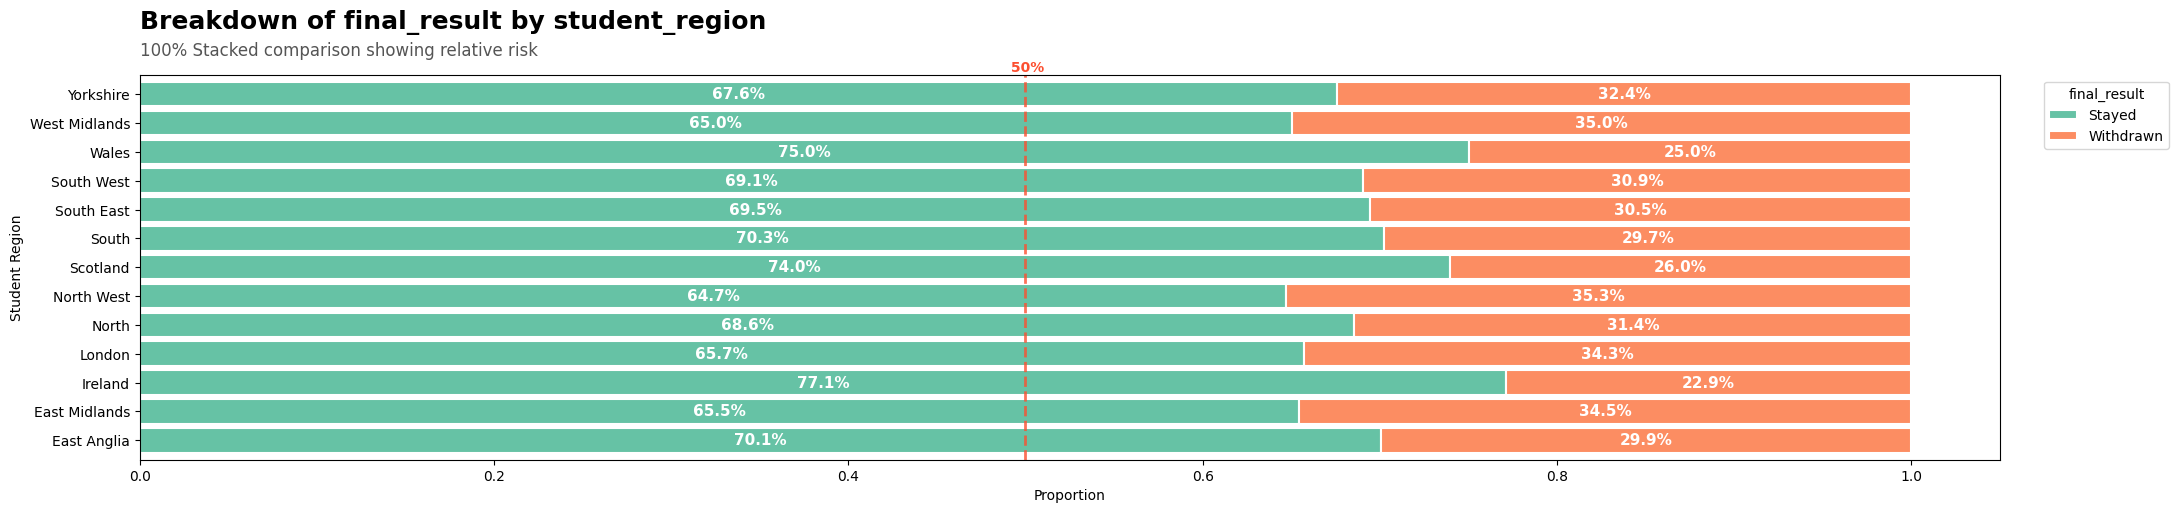

In [195]:
ct = pd.crosstab(data['student_region'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

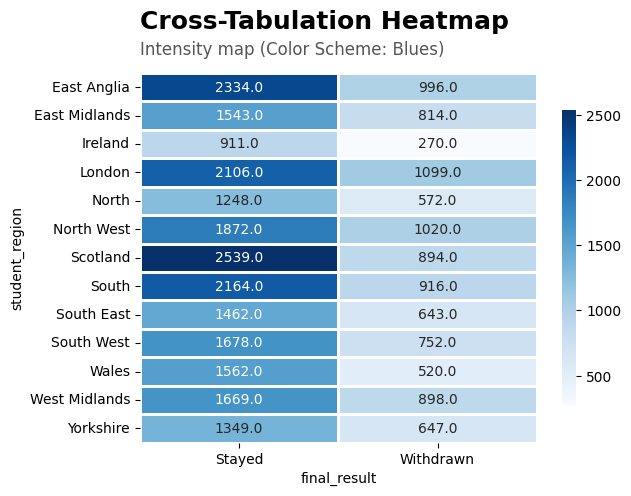

In [196]:
ct = pd.crosstab(data['student_region'],data['final_result'])
P.plot_heatmap(ct)

In [197]:
data['student_region'].unique()

array(['East Anglia', 'Scotland', 'North West', 'South East',
       'West Midlands', 'Wales', 'North', 'South', 'Ireland',
       'South West', 'East Midlands', 'Yorkshire', 'London'], dtype=object)

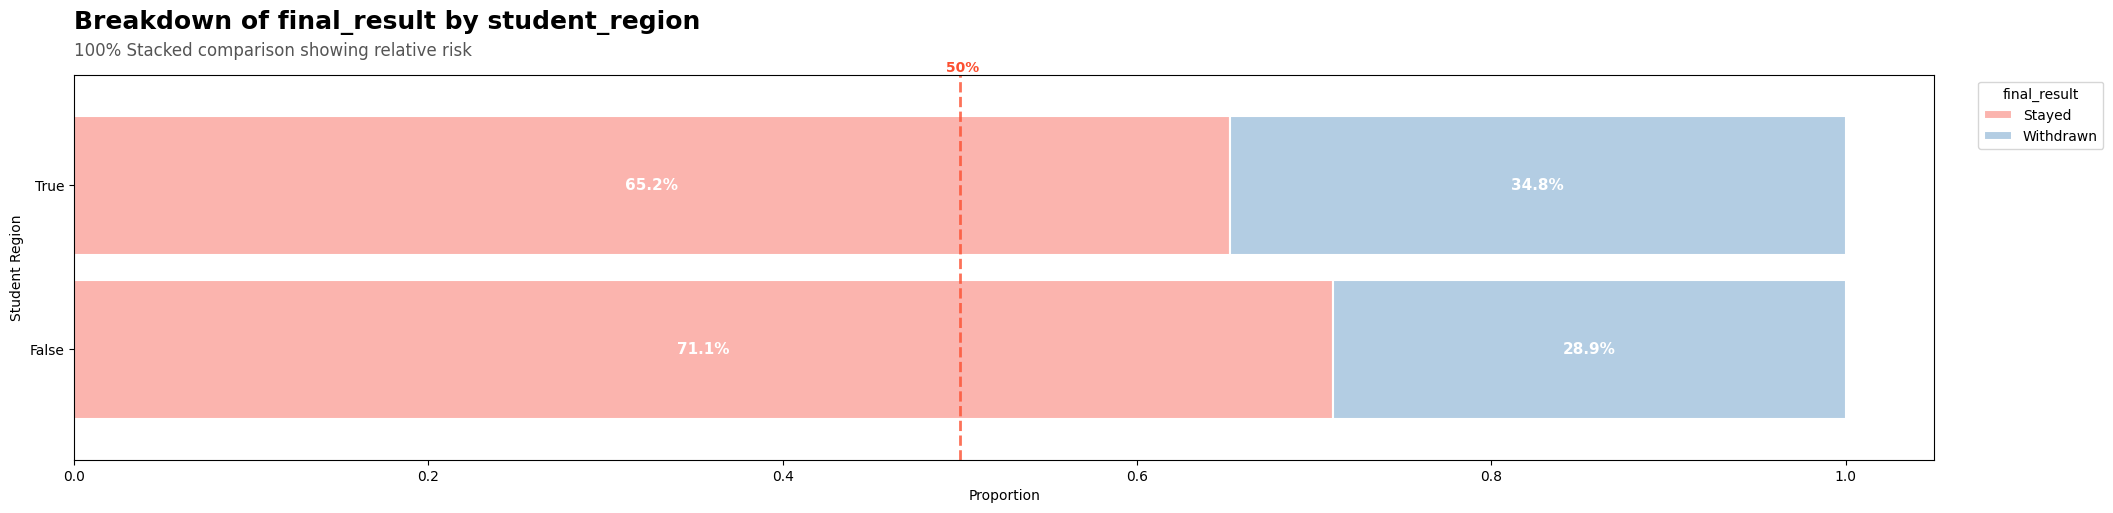

In [198]:
region_mask = (data['student_region']=='West Midlands') | (data['student_region']=='North West') | (data['student_region']=='London') | (data['student_region']=='East Midlands')
ct = pd.crosstab(region_mask,data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

In [199]:
ct = pd.crosstab(data['student_region'],data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.077 (Weak)


- ***by visuals we saw that some of the region have higher withdrawns,but statistical test says columns have weak association***

**qualification**

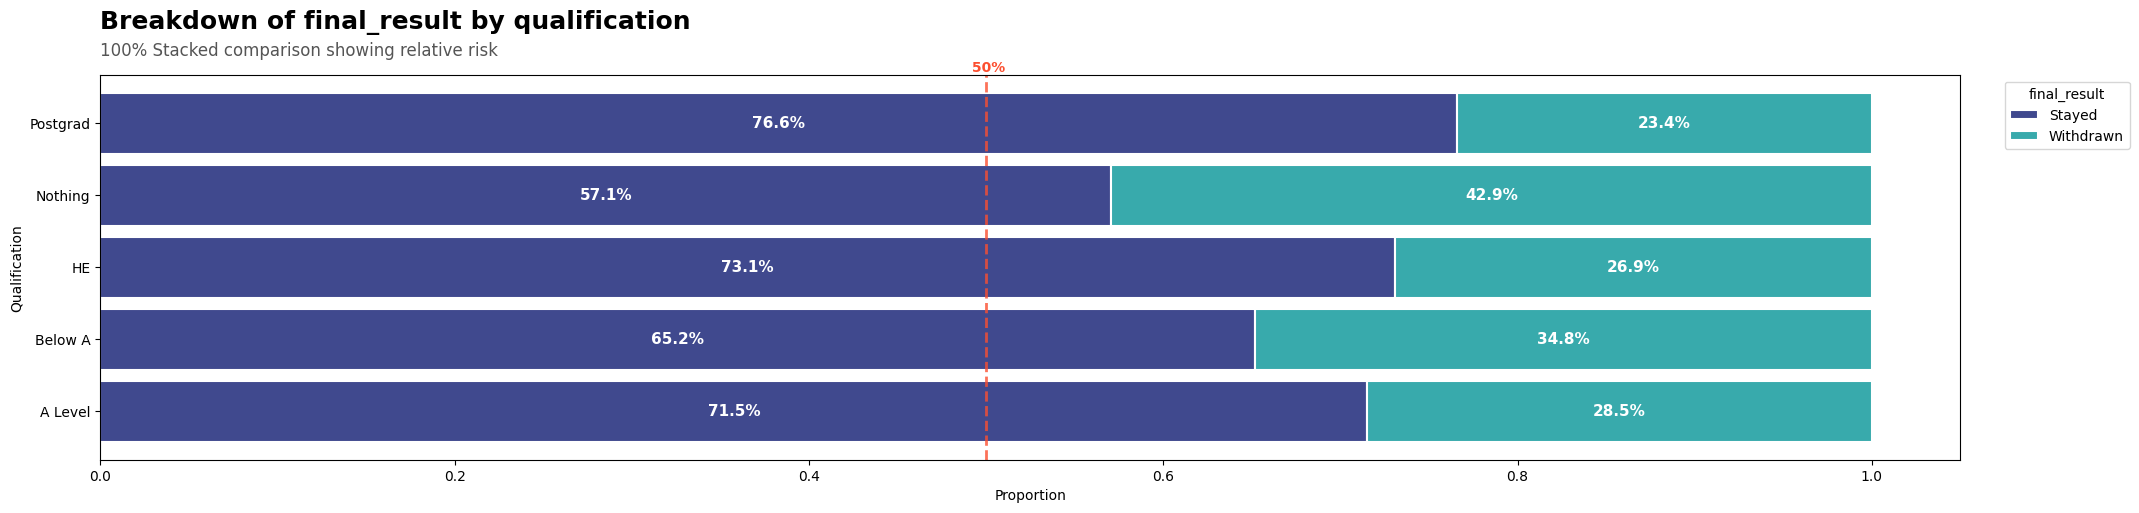

In [200]:
ct = pd.crosstab(data['qualification'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

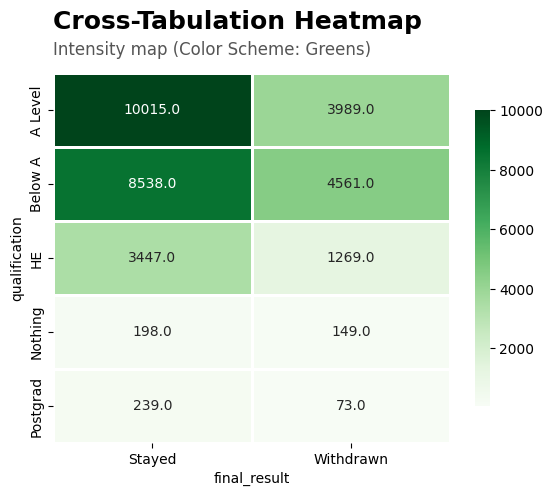

In [201]:
ct = pd.crosstab(data['qualification'],data['final_result'])
P.plot_heatmap(ct)

In [202]:
data['qualification'].unique()

array(['HE', 'A Level', 'Below A', 'Postgrad', 'Nothing'], dtype=object)

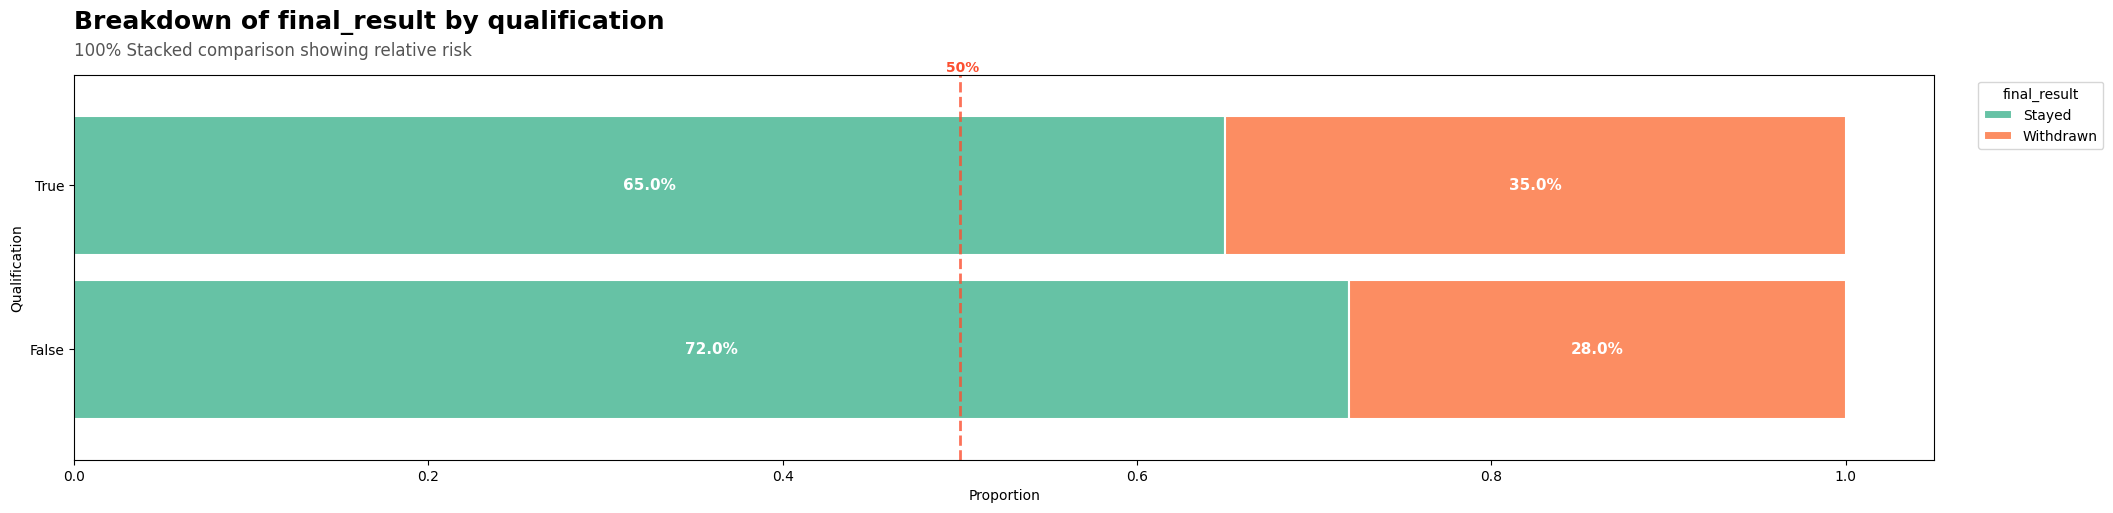

In [203]:
qualification_mask = (data['qualification']=='Below A') | (data['qualification']=='Nothing')
ct = pd.crosstab(qualification_mask,data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

In [204]:
ct = pd.crosstab(qualification_mask,data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.075 (Weak)


In [205]:
ct = pd.crosstab(data['qualification'],data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.078 (Weak)


- ***by visuals we saw some of the values have higher withdrawn, but statistical analysis says both columns have weak association***

**imd_band**

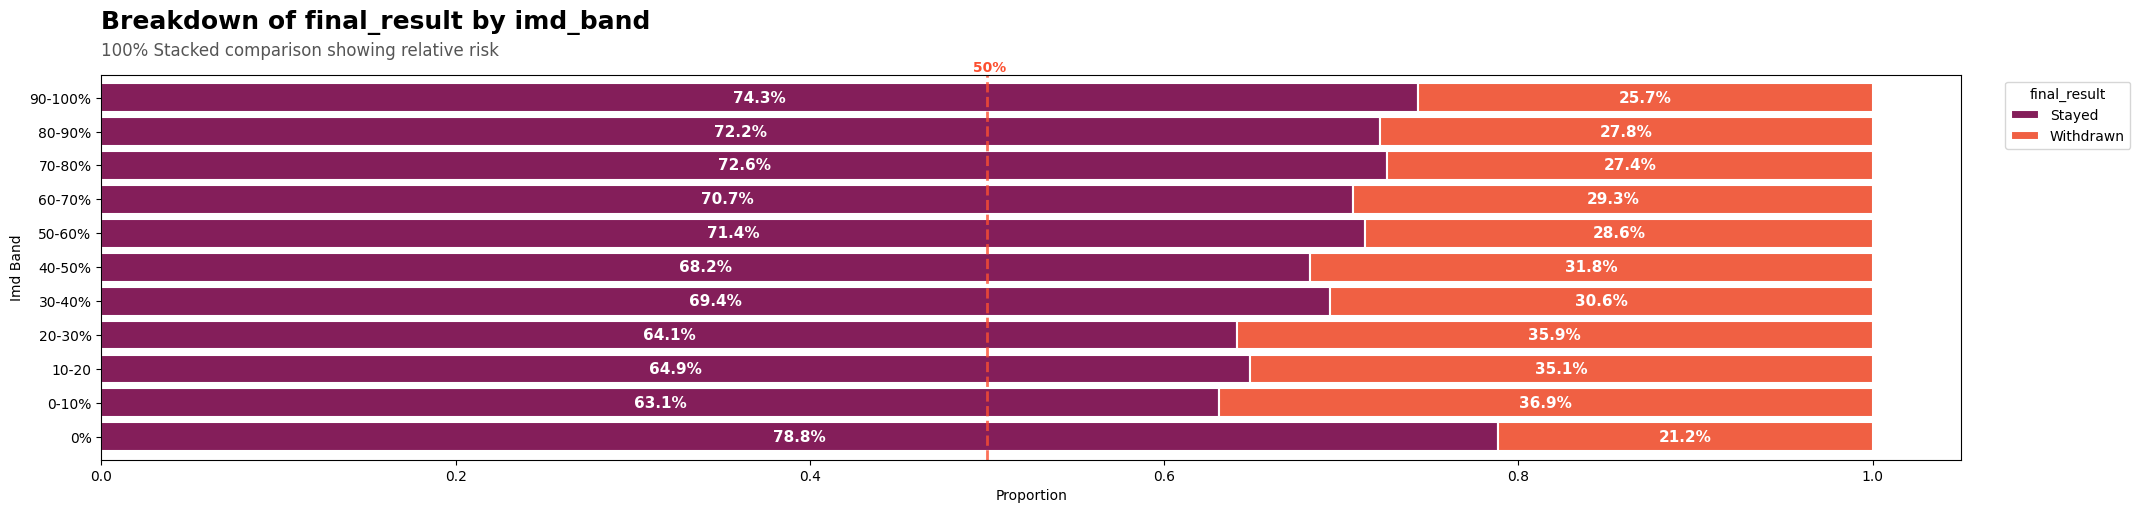

In [206]:
ct = pd.crosstab(data['imd_band'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

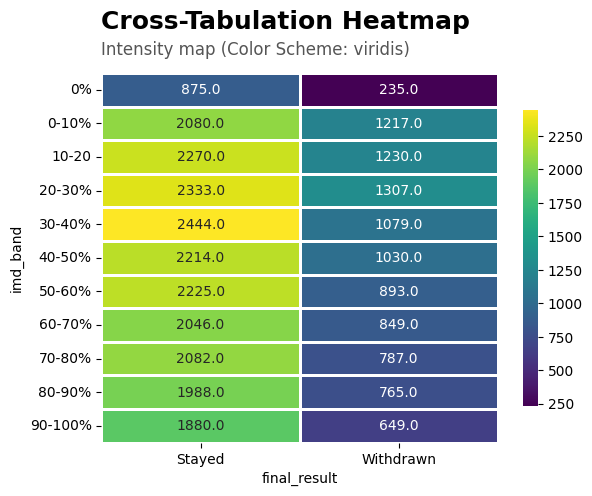

In [207]:
ct = pd.crosstab(data['imd_band'],data['final_result'])
P.plot_heatmap(ct)

In [208]:
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.088 (Weak)


- ***by visuals we did not saw any specific pattern, and statistical test says both columns have weak associations***

**age_band**

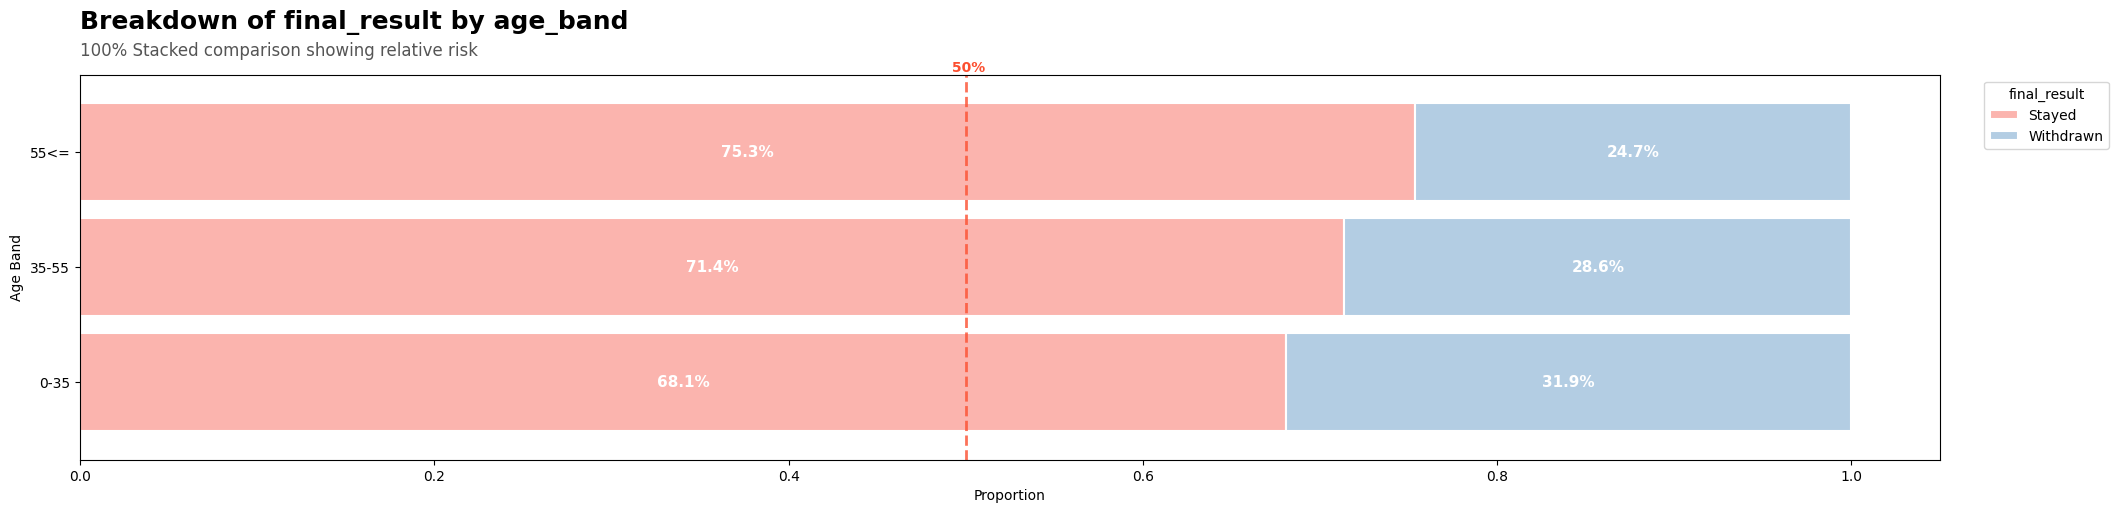

In [209]:
ct = pd.crosstab(data['age_band'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

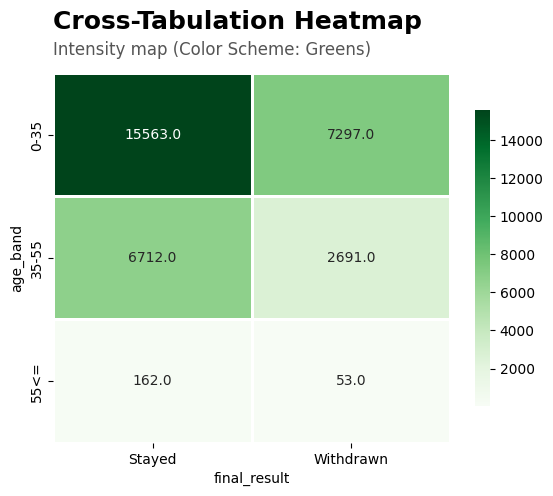

In [210]:
ct = pd.crosstab(data['age_band'],data['final_result'])

P.plot_heatmap(ct)

In [211]:
ct = pd.crosstab(data['age_band'],data['final_result'])

S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.034 (Weak)


- ***from visuals we saw pattern, but statistical test says the association is weak - maybe the sample size is small for 55+***

**disability**

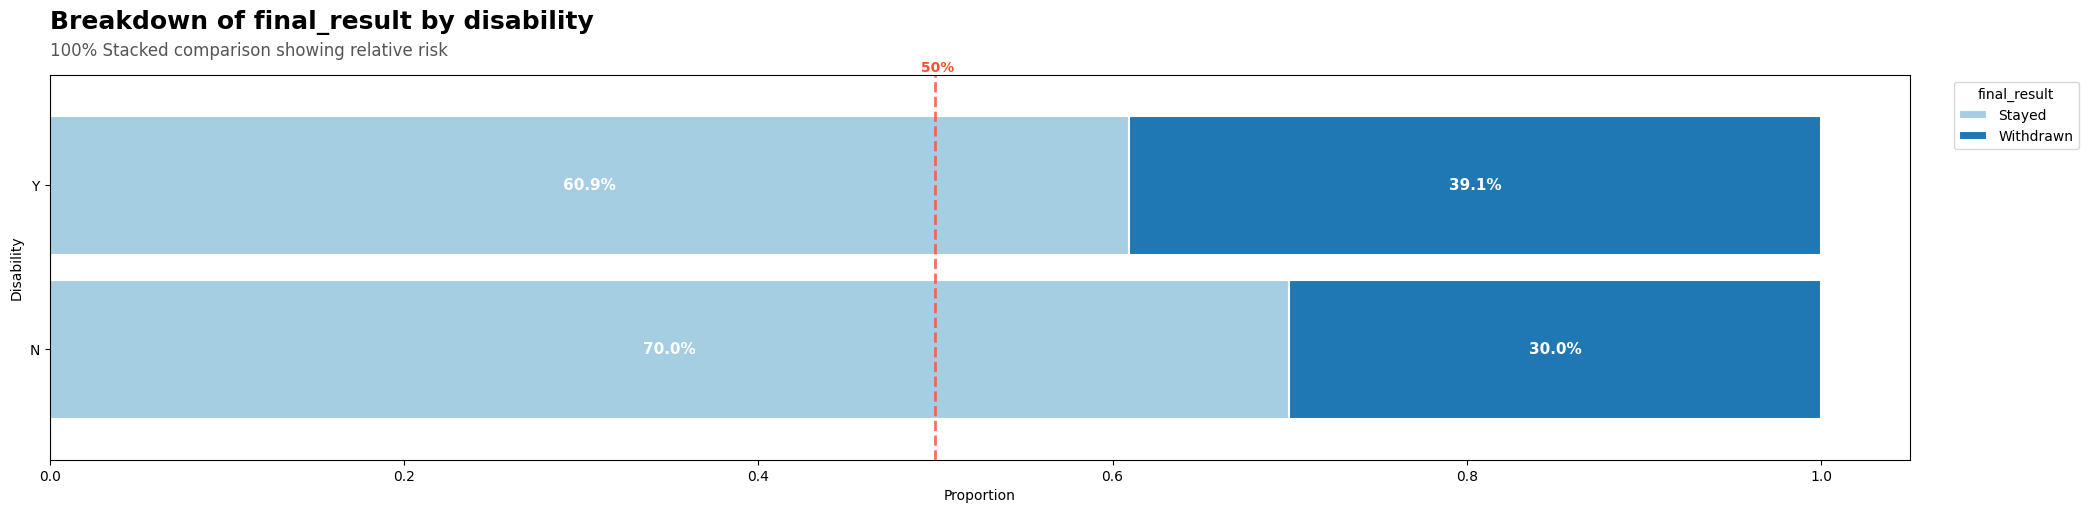

In [212]:
ct = pd.crosstab(data['disability'],data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct,orient='h')

In [213]:
ct = pd.crosstab(data['disability'],data['final_result'])

S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.058 (Weak)


- ***by visuals we did not saw anything specific, and statistical test says the association is weak***

**NUMERICAL COLUMNS WITH `final_result` COLUMN**

**credits**

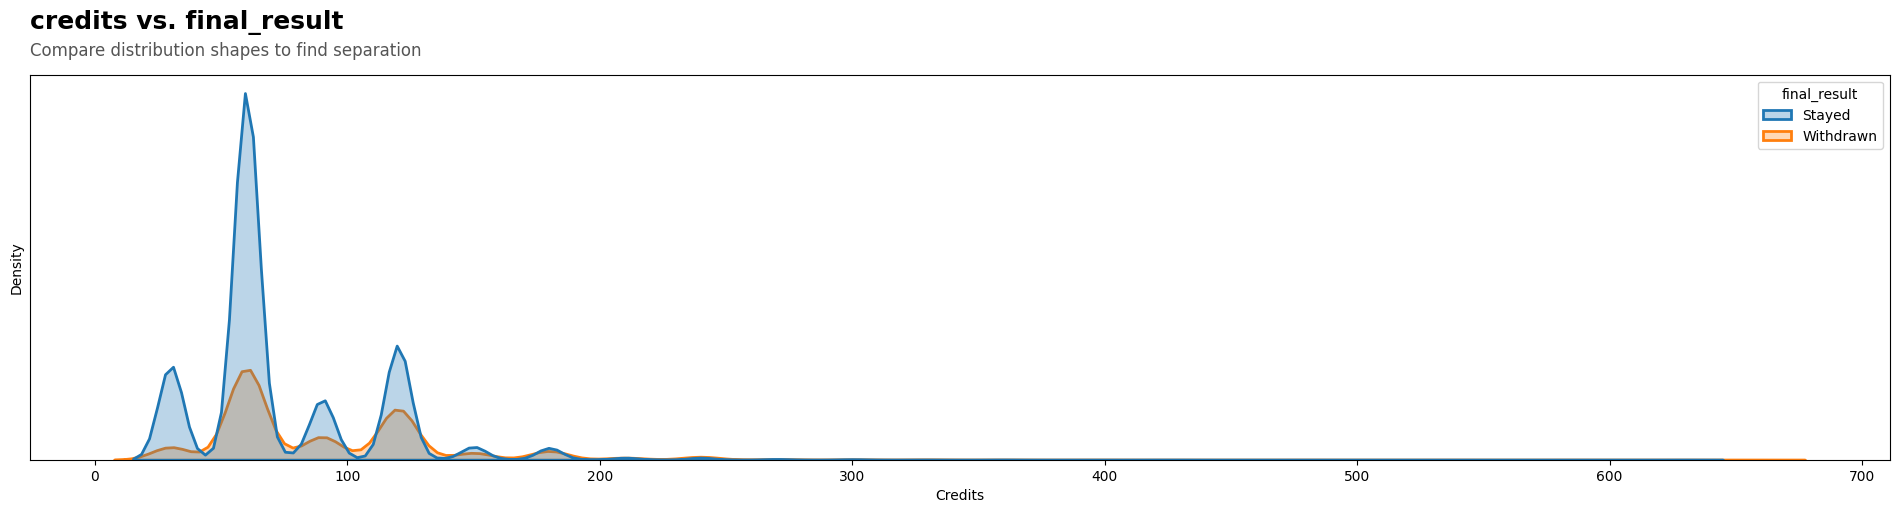

In [214]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='credits',data= data,target='final_result')

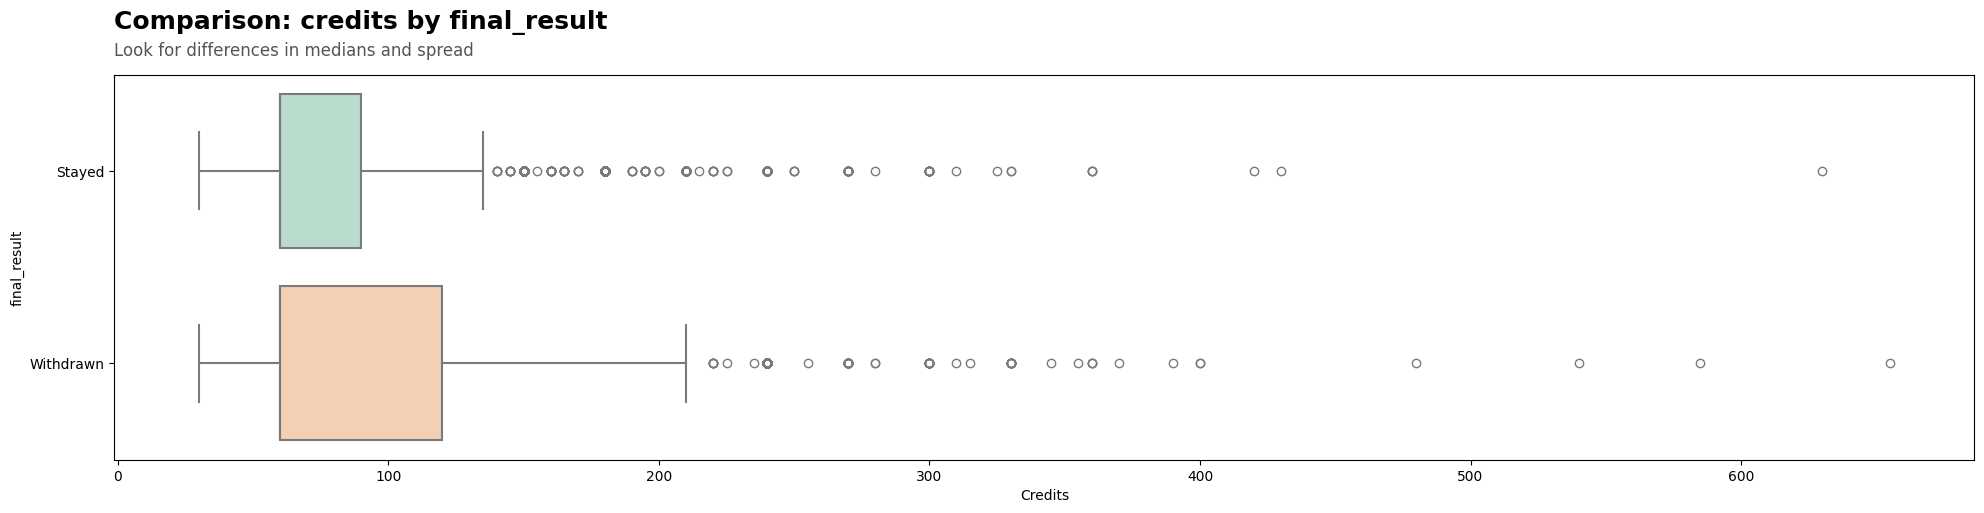

In [215]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='credits',data= data,target='final_result')

In [216]:
data.groupby('final_result')['credits'].describe().round(2).T

final_result    Stayed  Withdrawn
count         22437.00   10041.00
mean             74.48      91.35
std              36.81      47.15
min              30.00      30.00
25%              60.00      60.00
50%              60.00      60.00
75%              90.00     120.00
max             630.00     655.00

In [217]:
S.compare_means(data,'final_result','credits','Withdrawn')


=== Comparing 'credits' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = 0.419 (Small)


Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


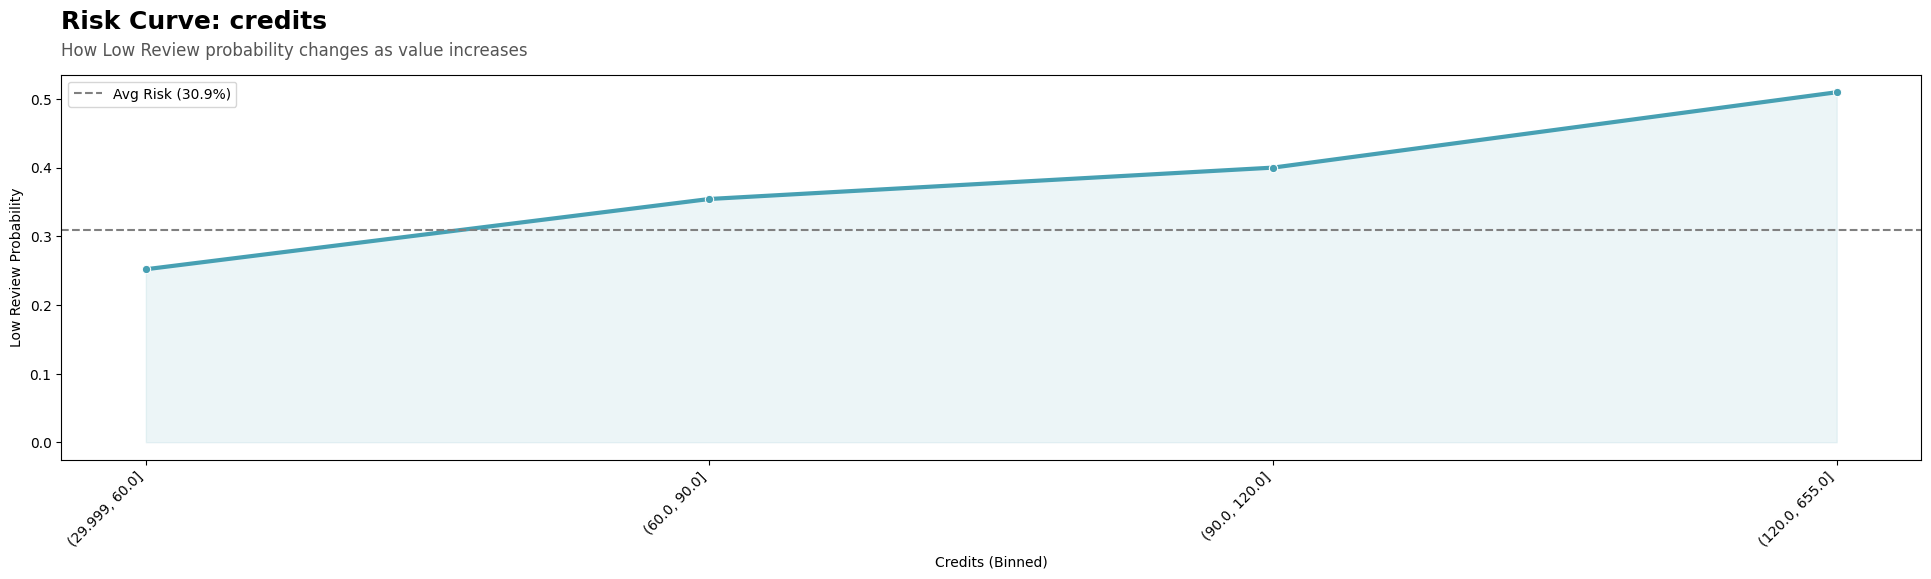

In [218]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'credits','final_result',bins = 10)

In [219]:
credit_groups = pd.cut(data['credits'], 
                         bins=[0, 60,121, float('inf')], 
                         labels=['Short','Medium','High'])

ct_duration = pd.crosstab(credit_groups, data['final_result'])

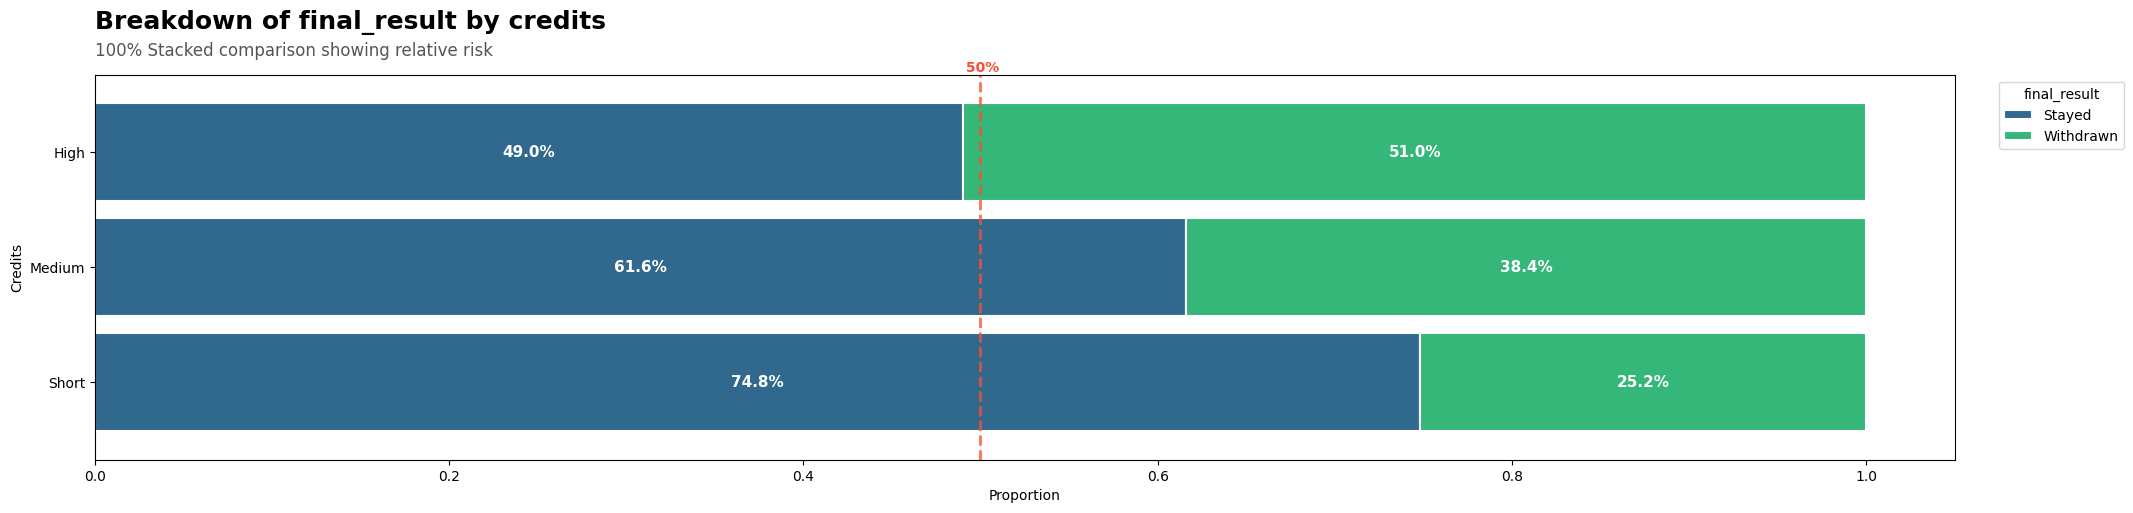

In [220]:
ct_credits_normalized = pd.crosstab(credit_groups, data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct_credits_normalized,orient='h')

In [221]:
ct_duration = pd.crosstab(credit_groups, data['final_result'])
S.test_association(ct)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.058 (Weak)


- ***by visuals we saw that higher the credit more the chance of withdrawn, but statistical analysis says the association is weak***

**registration**

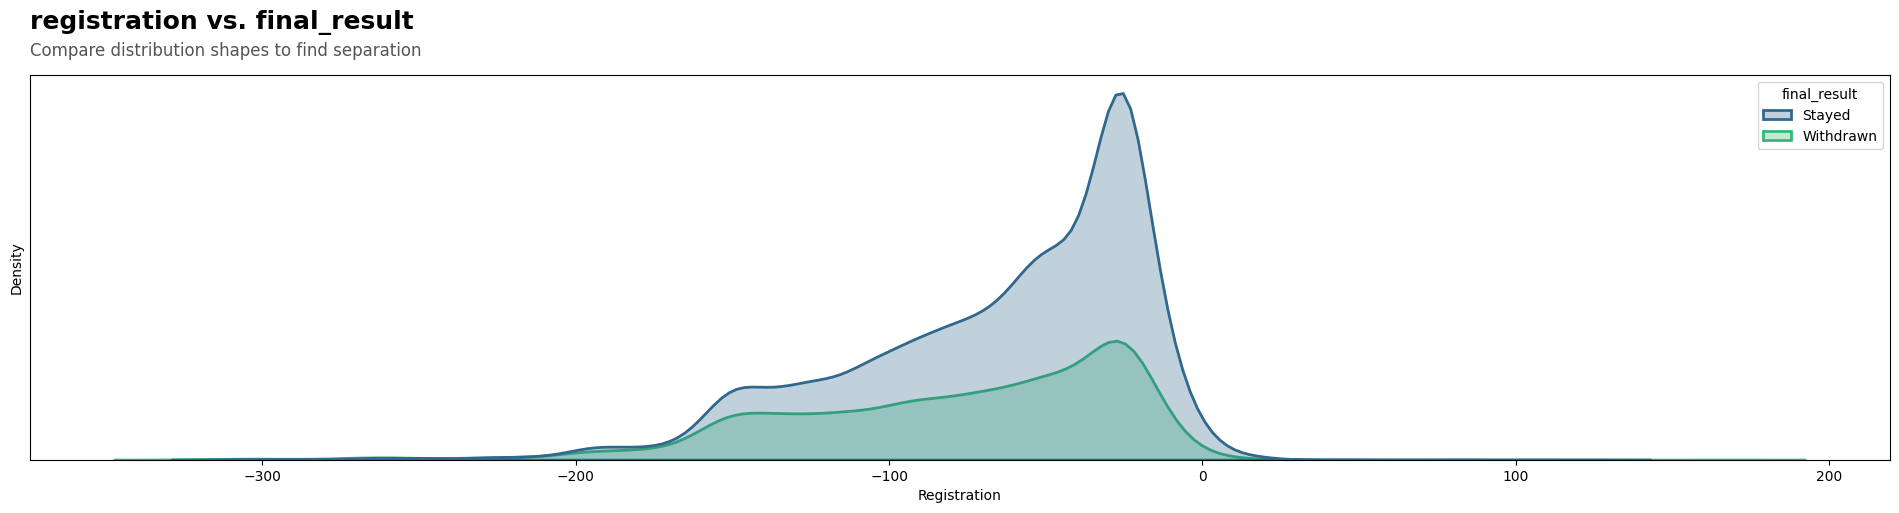

In [222]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='registration',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


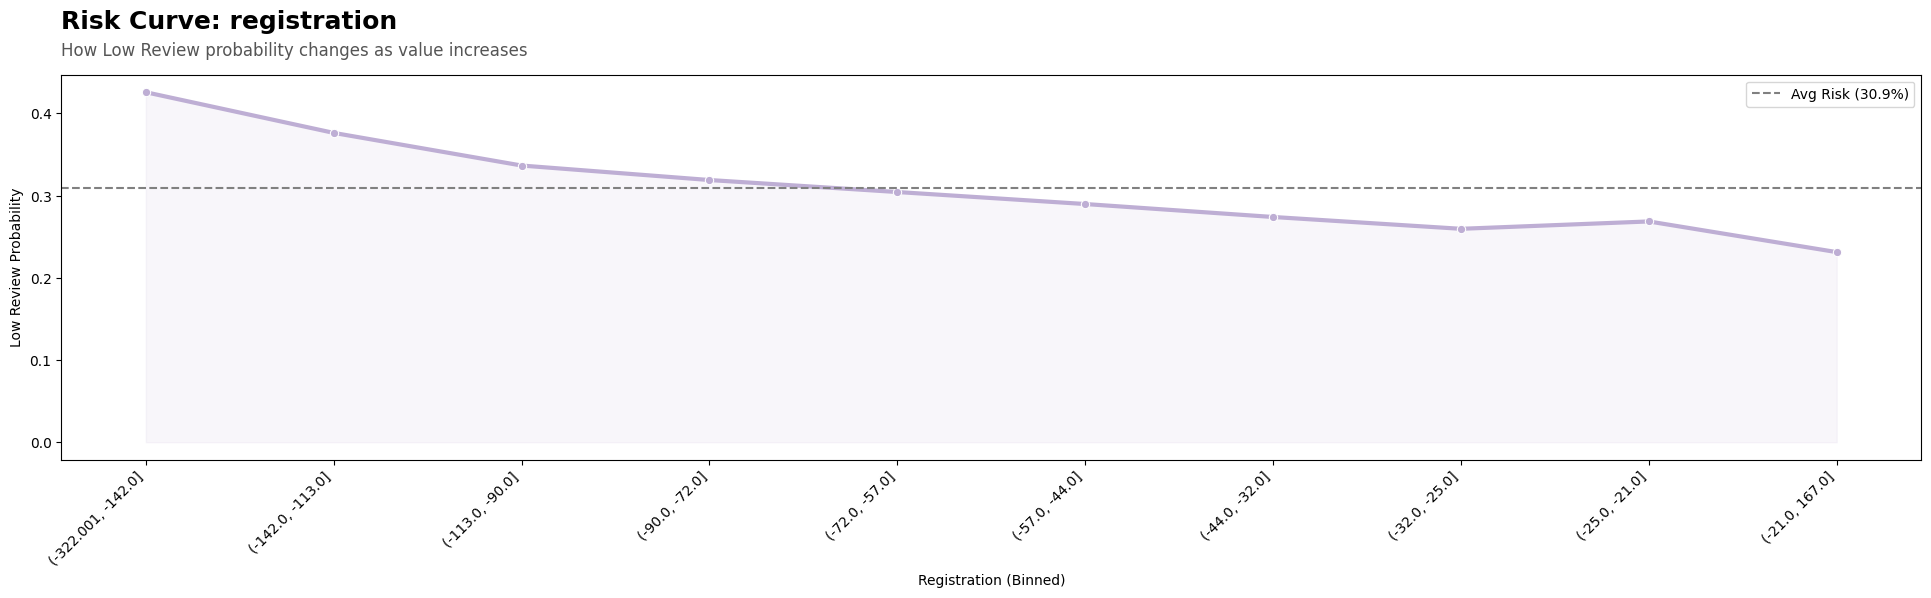

In [223]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'registration','final_result',bins = 10)

In [224]:
S.compare_means(data,'final_result','registration','Withdrawn')


=== Comparing 'registration' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = -0.269 (Small)


In [225]:
registration_groups = pd.cut(data['registration'], 
                         bins=[float('-inf'), -89, -31, float('inf')], 
                         labels=['prior to 3+ month', 'prior to 1 month','starting time'])

ct_registration = pd.crosstab(registration_groups, data['final_result'])

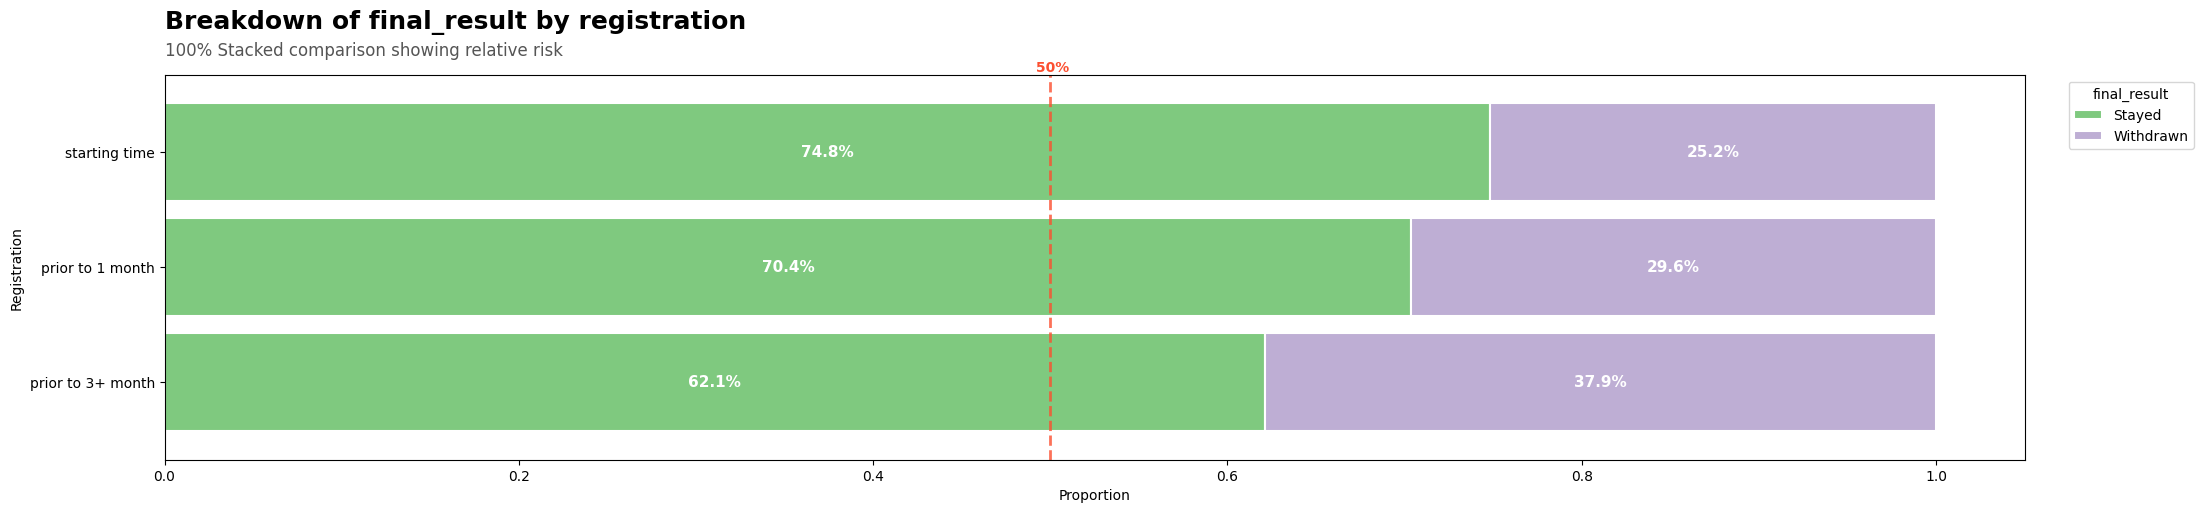

In [226]:
ct_registration_normalized = pd.crosstab(registration_groups, data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct_registration_normalized,orient='h')

In [227]:
S.test_association(ct_registration)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.107 (Moderate)


In [228]:
data['registration'].corr(data['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)).round(2)

np.float64(-0.12)

***
- ***from visuals we saw that e`arlier the registration, more the risk of readmission`, after doing statistical test, we can validate this assumption***
***

**vle_used**

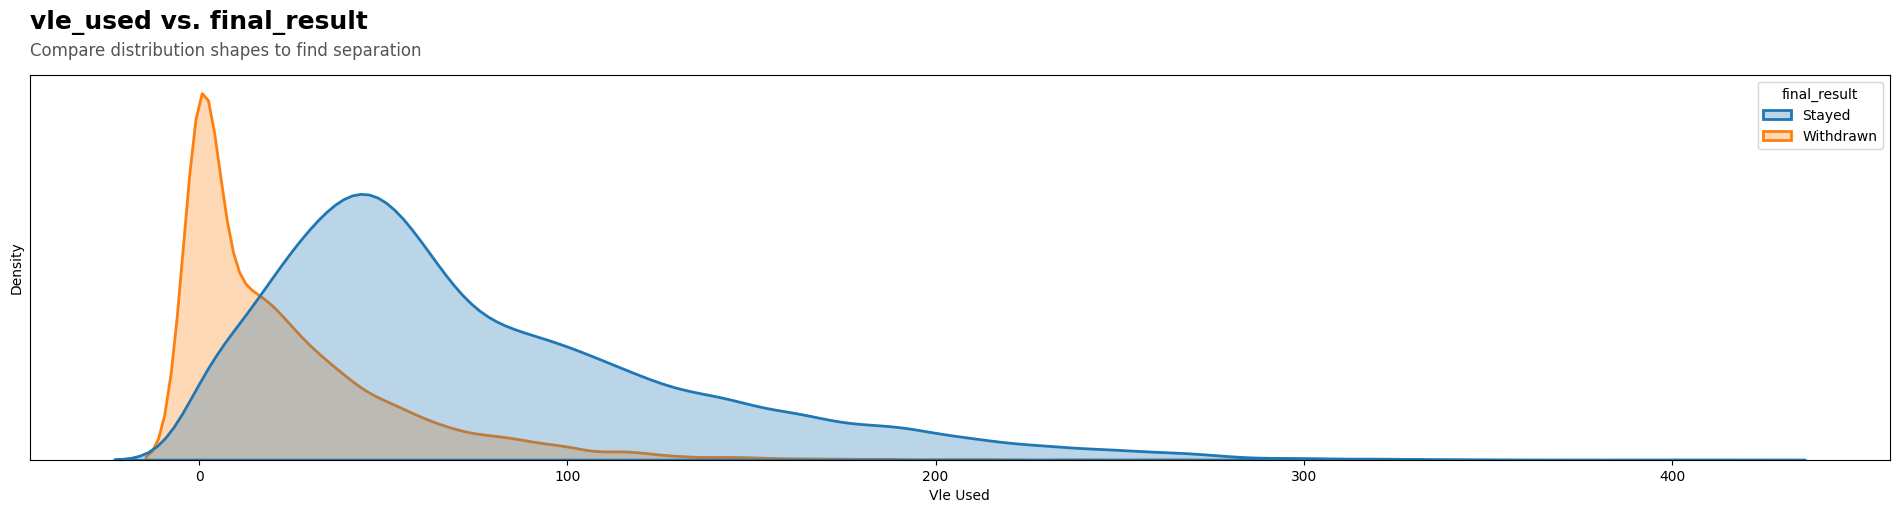

In [229]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='vle_used',data= data,target='final_result')

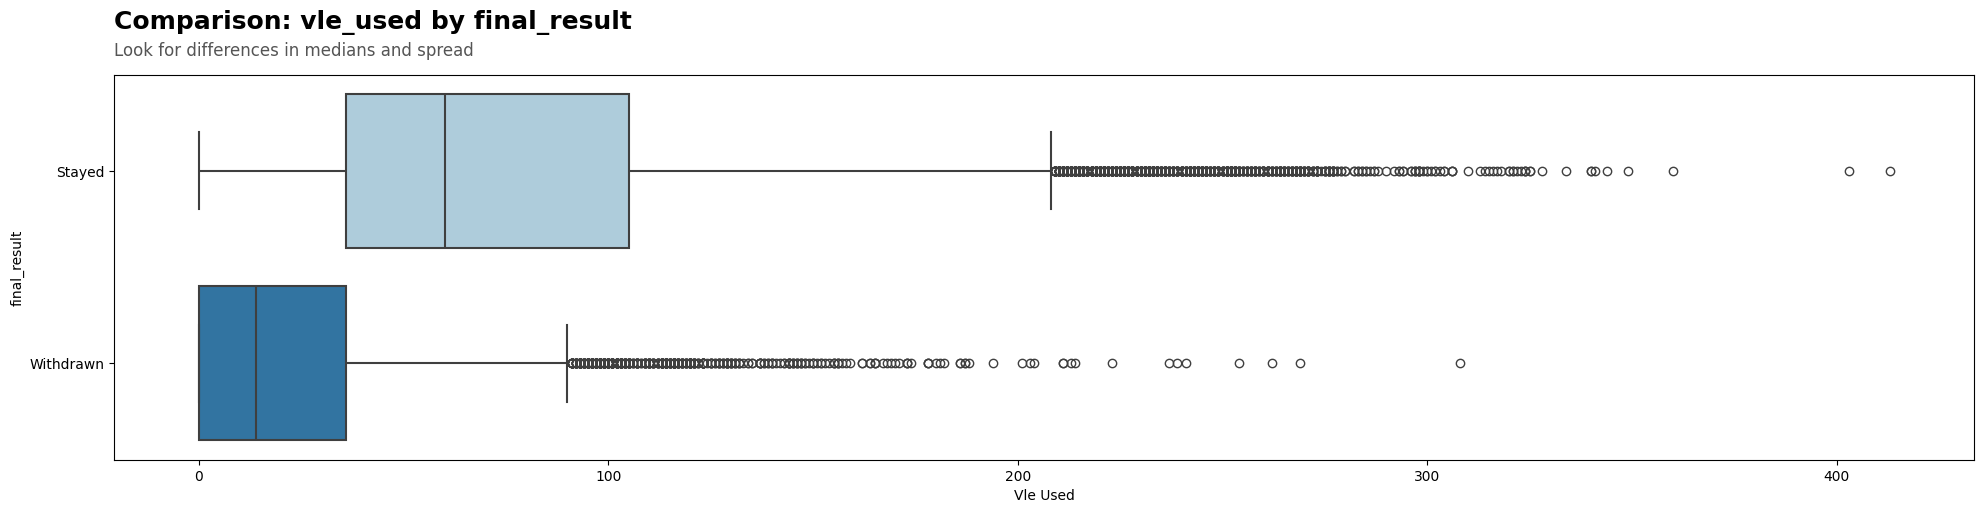

In [230]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='vle_used',data= data,target='final_result')

In [231]:
data.groupby('final_result')['vle_used'].describe().round(2).T

final_result    Stayed  Withdrawn
count         22437.00   10041.00
mean             76.41      24.33
std              57.16      30.67
min               0.00       0.00
25%              36.00       0.00
50%              60.00      14.00
75%             105.00      36.00
max             413.00     308.00

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


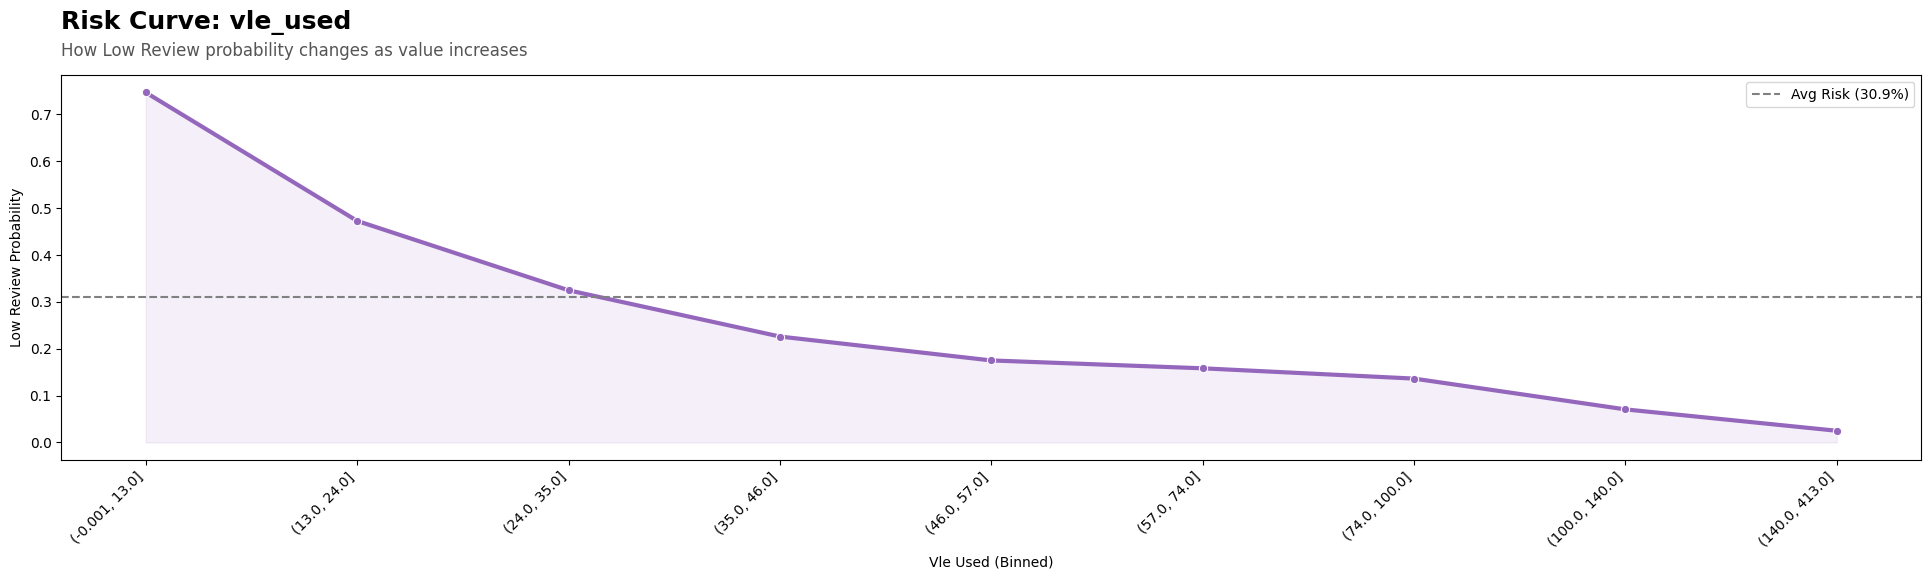

In [232]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'vle_used','final_result',bins = 10)

In [233]:
S.compare_means(data,'final_result','vle_used','Withdrawn')


=== Comparing 'vle_used' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = -1.032 (Large)


***
- ***by visuals we saw that `higher the usage of vle, lower the chance of withdrawn` - after doing statistical test, we can validate this assumption***
***

**clicks**

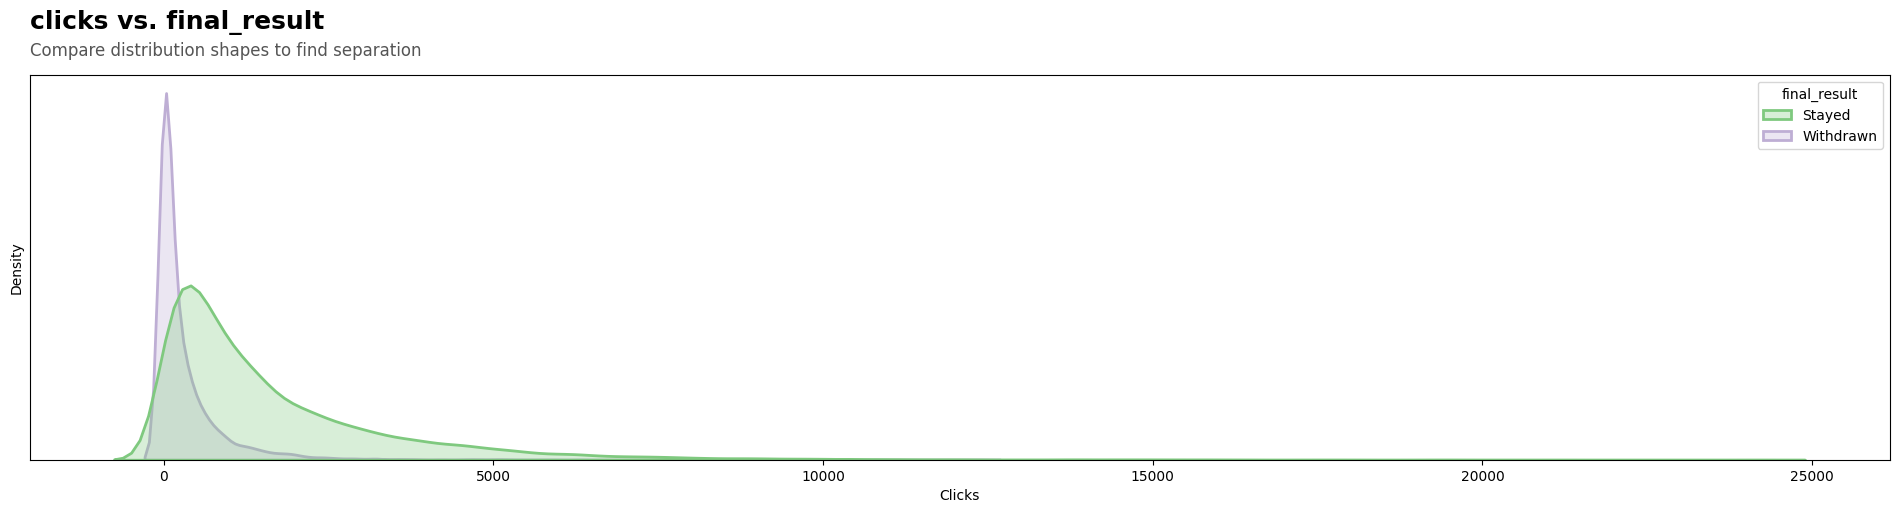

In [234]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='clicks',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


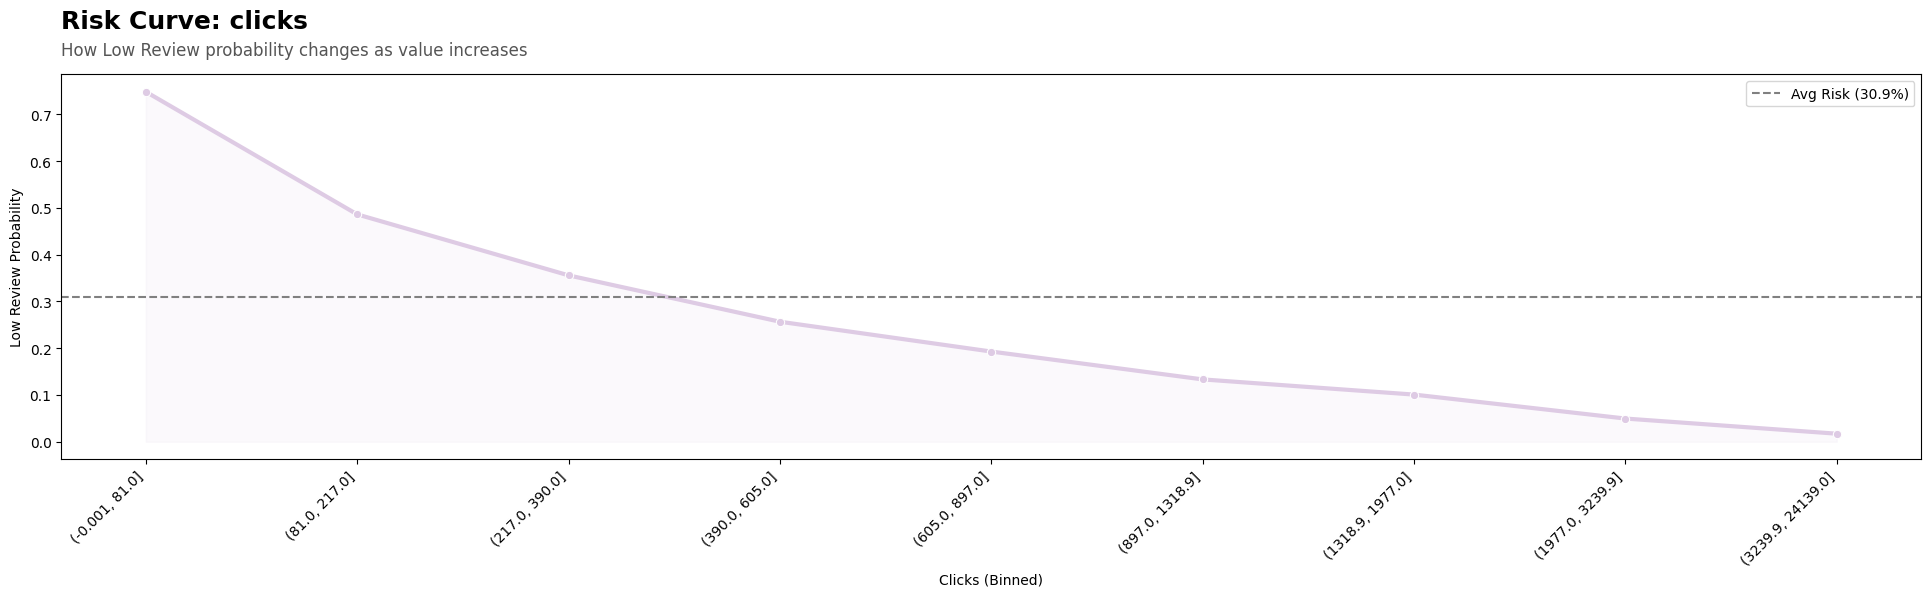

In [235]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'clicks','final_result',bins = 10)

In [236]:
S.compare_means(data,'final_result','clicks','Withdrawn')


=== Comparing 'clicks' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = -0.826 (Large)


***
- ***by visuals we saw that `higher the usage of clicks, lower the chance of withdrawn` - after doing statistical test, we can validate this assumption***
***

**assessments**

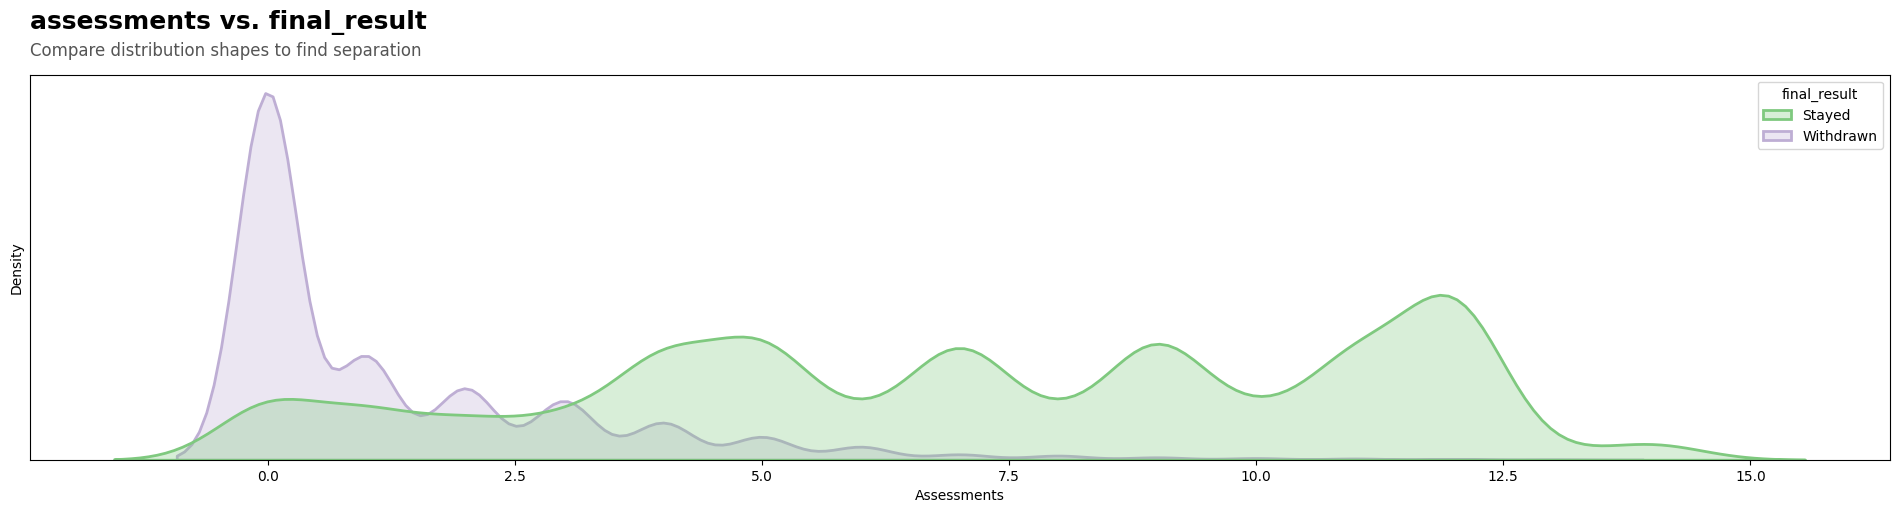

In [237]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='assessments',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


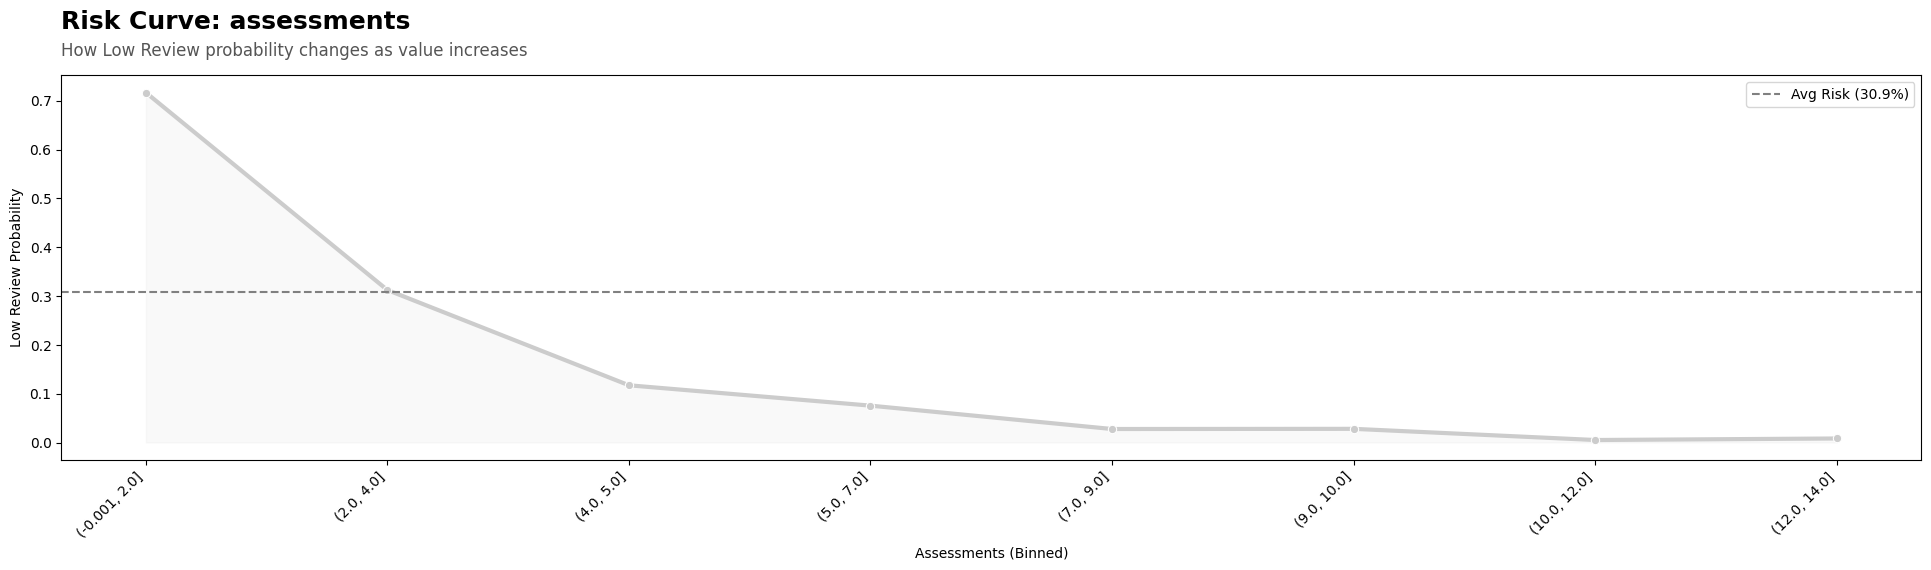

In [238]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'assessments','final_result',bins = 10)

In [239]:
S.compare_means(data,'final_result','assessments','Withdrawn')


=== Comparing 'assessments' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = -1.743 (Large)


***
- ***by visuals we saw that `higher the appearing of assessment, lower the chance of withdrawn` - after doing statistical test, we can validate this assumption***
***

**attempted_assessments**

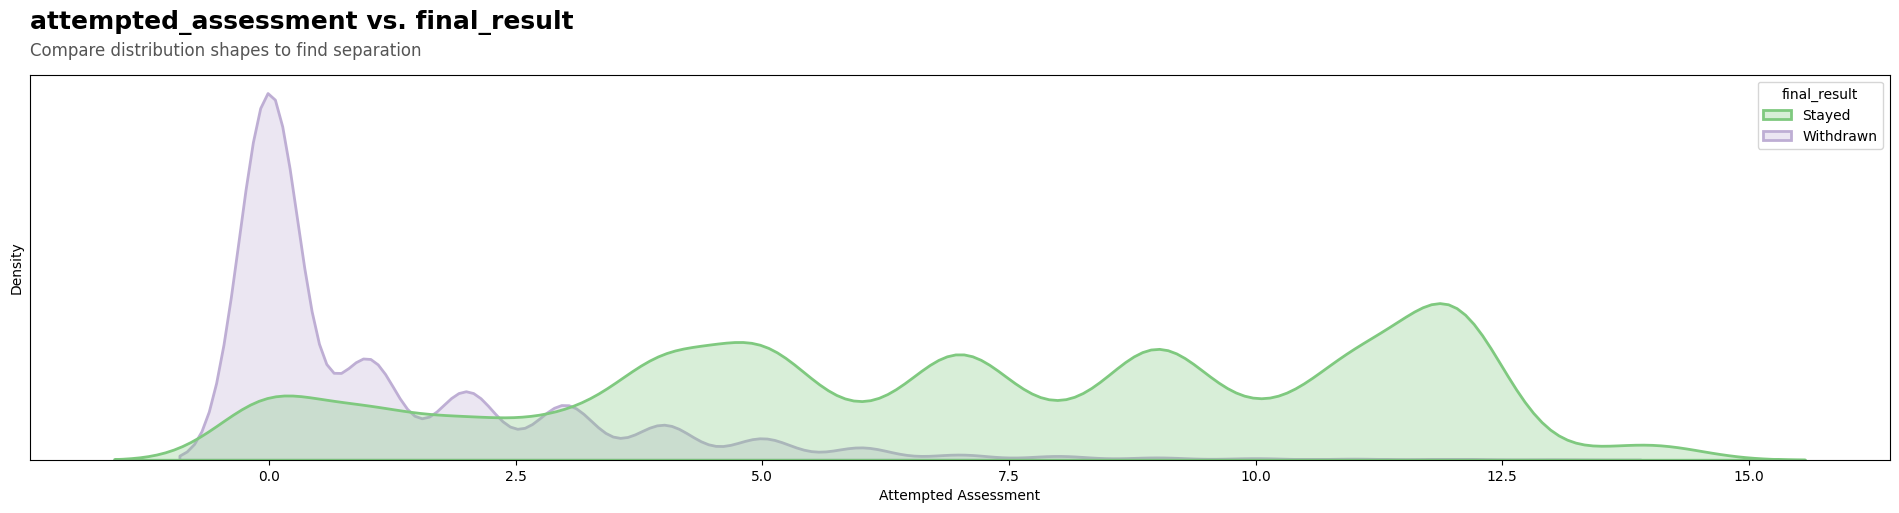

In [240]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='attempted_assessment',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


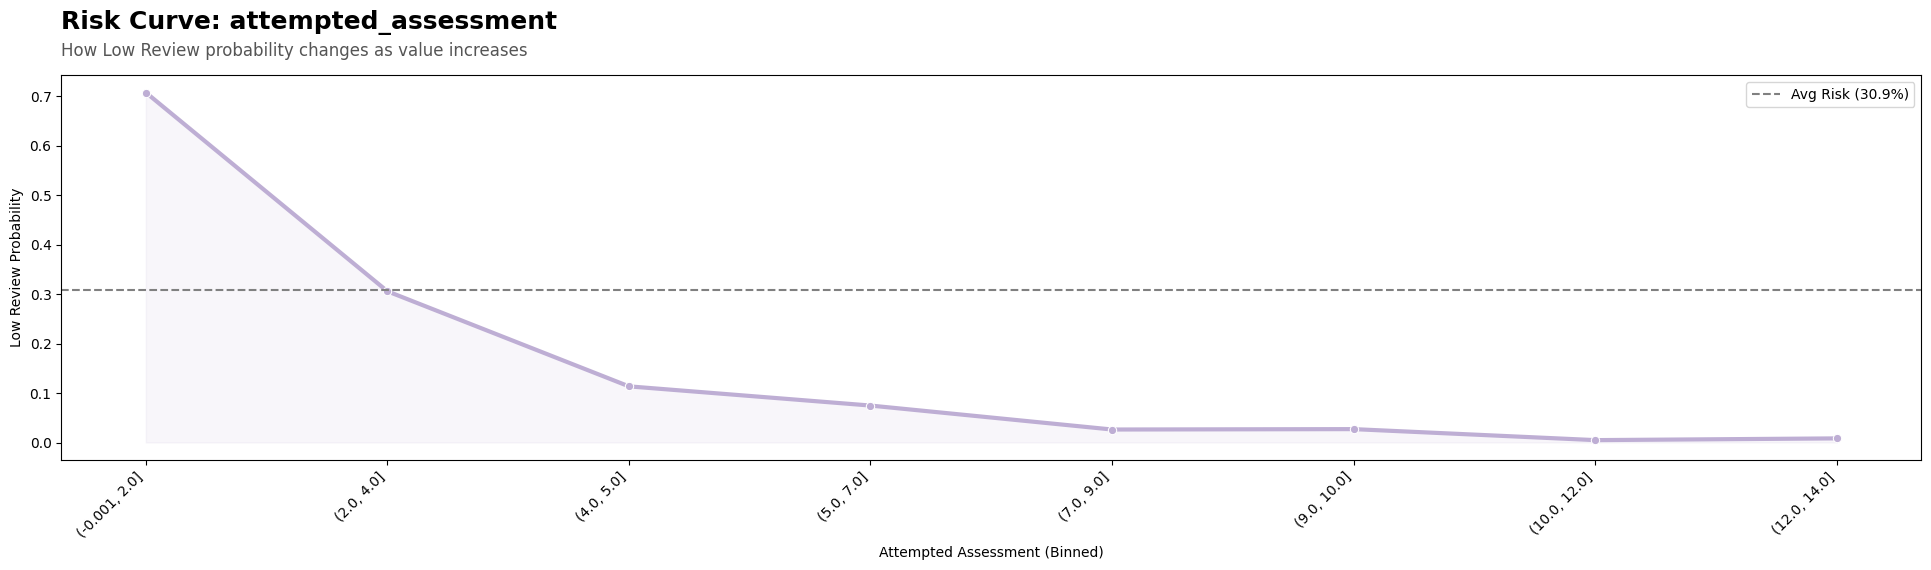

In [241]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'attempted_assessment','final_result',bins = 10)

In [242]:
S.compare_means(data,'final_result','attempted_assessment','Withdrawn')


=== Comparing 'attempted_assessment' by Group 'final_result' ===
Group 1 (Withdrawn): n=10041 | Group 2 (Others): n=22437
Test Used:      T-Test (Unequal Variance)
Normality:      Sample size > 5000 (CLT assumed) -> Pass
P-Value:        0.00000
Verdict:        Significant Difference ✅
Effect Size:    Cohen's d = -1.722 (Large)


***
- ***by visuals we saw that `higher the attempt of assessment, lower the chance of withdrawn` - after doing statistical test, we can validate this assumption***
***

**score**

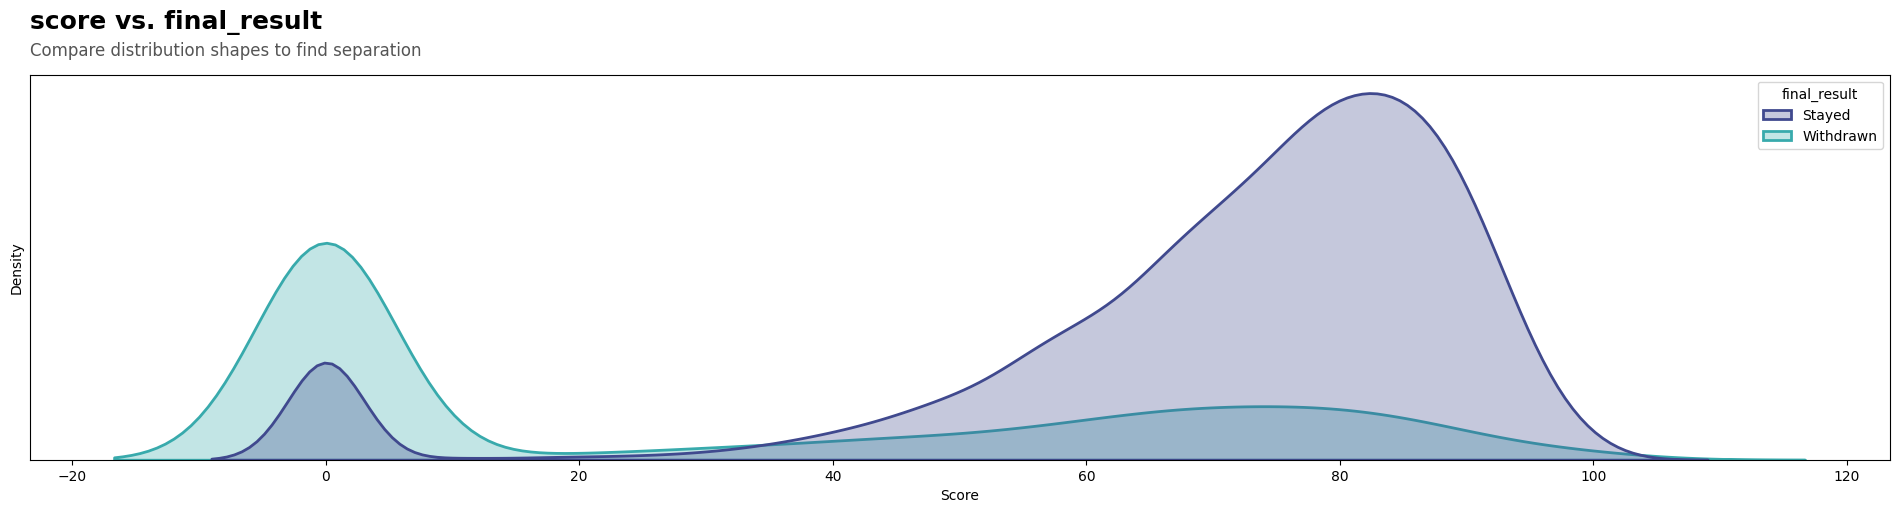

In [243]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='score',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


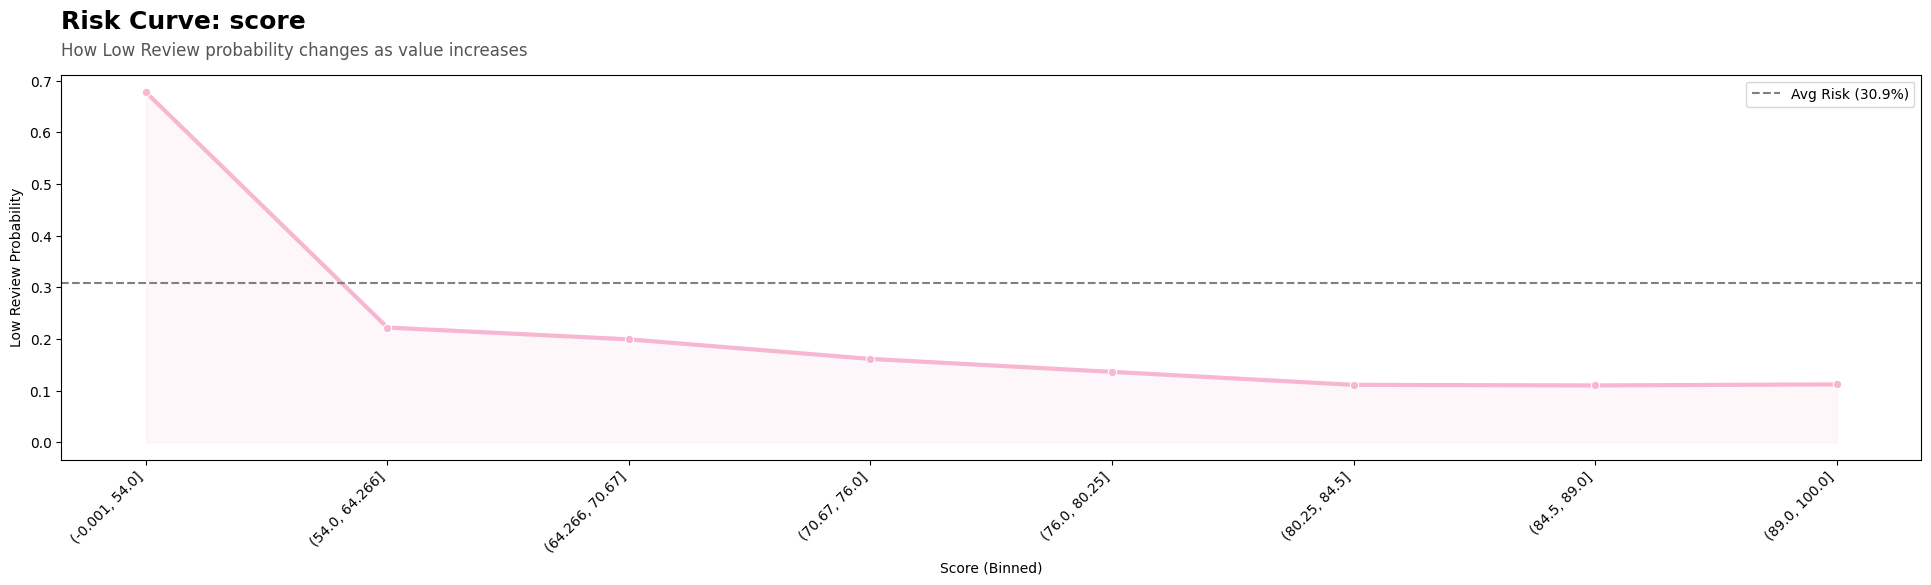

In [244]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'score','final_result',bins = 10)

In [245]:
score_groups = pd.cut(data['score'], 
                         bins=[-1, 55,100], 
                         labels=['Under 50', 'Over 50'])

ct_score = pd.crosstab(score_groups, data['final_result'])

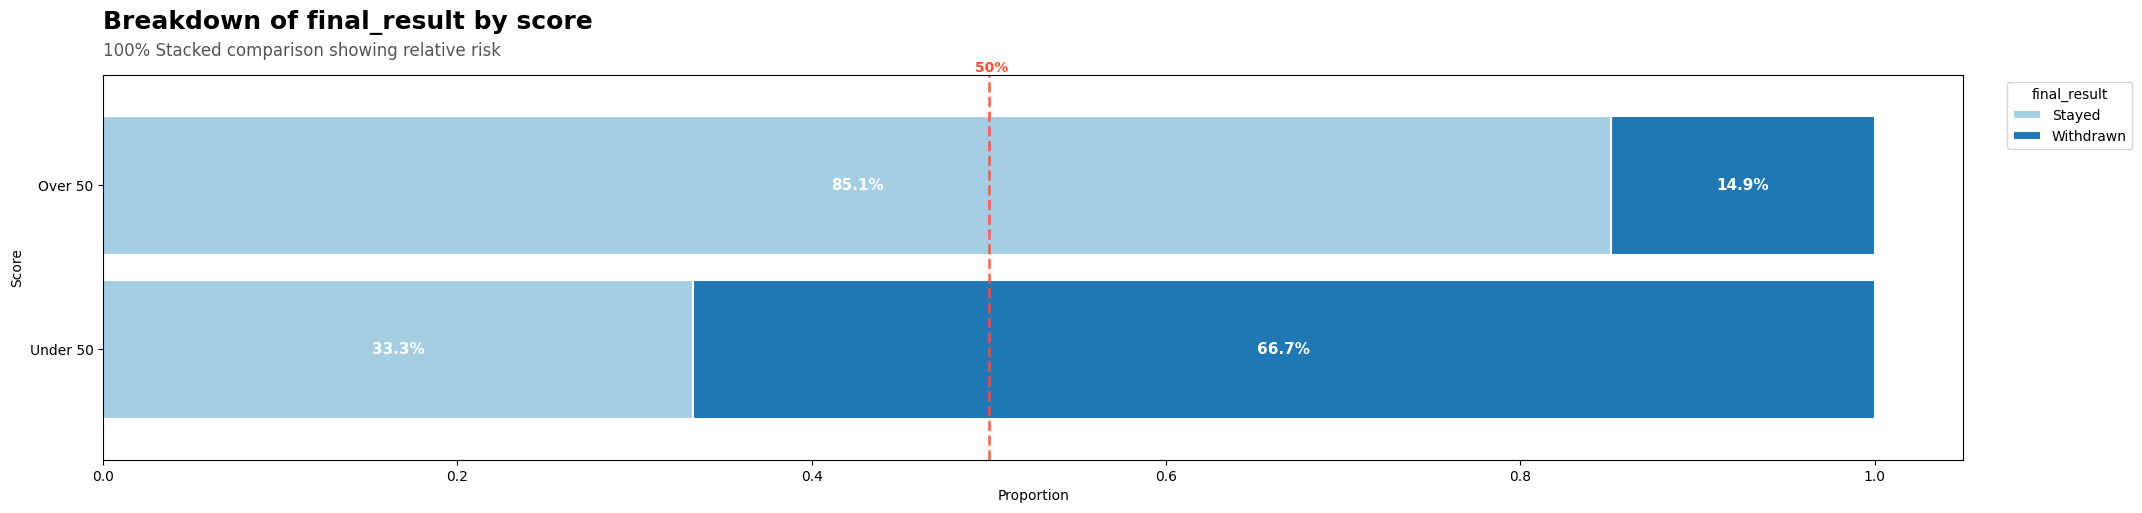

In [246]:
ct_score_normalized = pd.crosstab(score_groups, data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct_score_normalized,orient='h')

In [247]:
S.test_association(ct_score)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.518 (Strong)


***
- ***by visuals we saw that `score less than 50 have more occurances or withdrawn` - after doing statistical test we can validate this relationship with strong strength***
***

**clicks_per_vle**

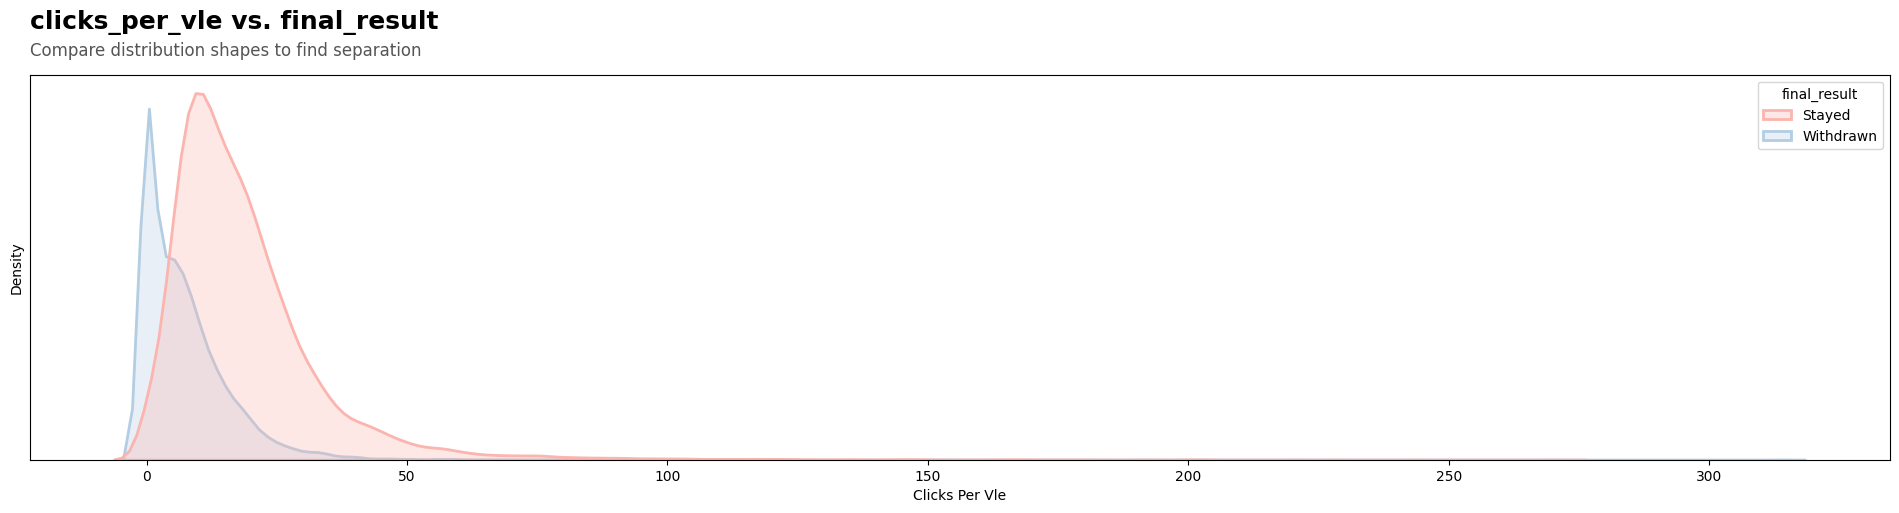

In [248]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='clicks_per_vle',data= data,target='final_result')

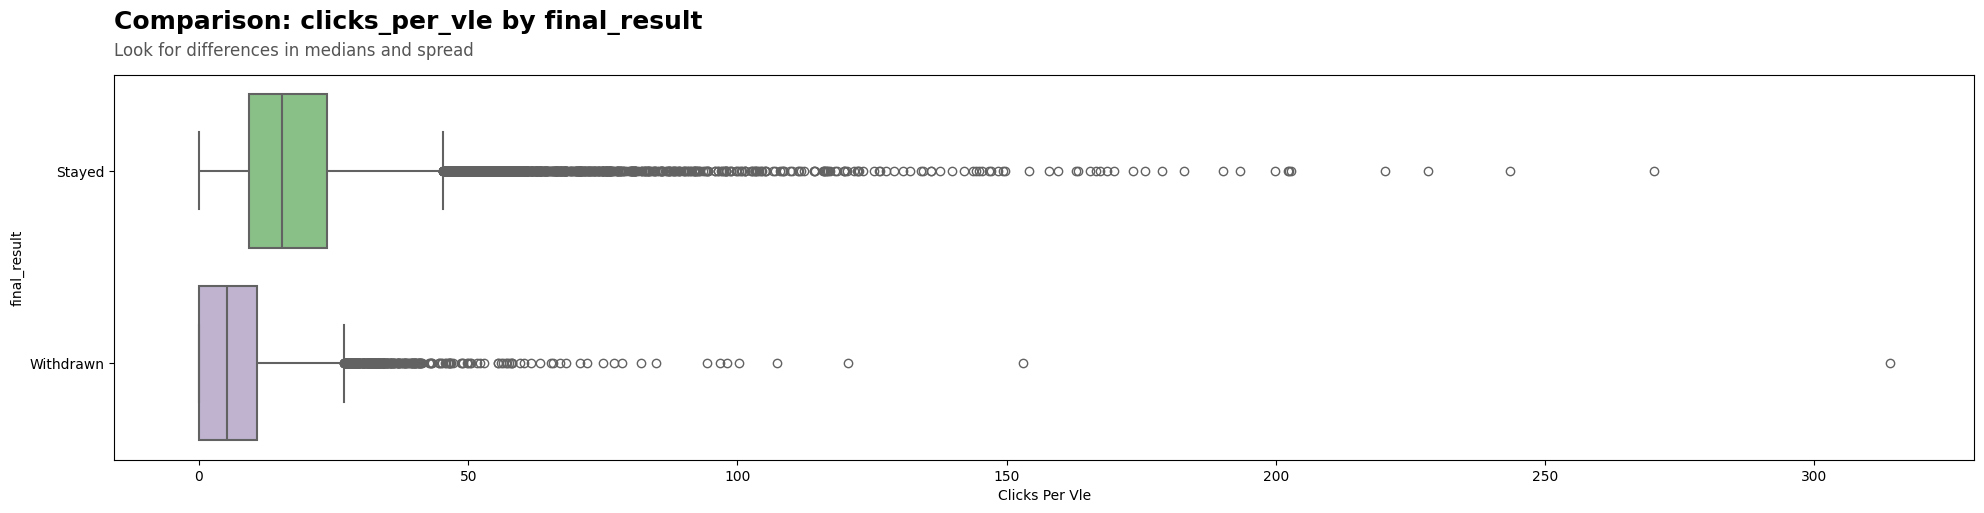

In [249]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='clicks_per_vle',data= data,target='final_result')

Note: Converted 'final_result' from Withdrawn/Stayed to 1/0 for this plot.


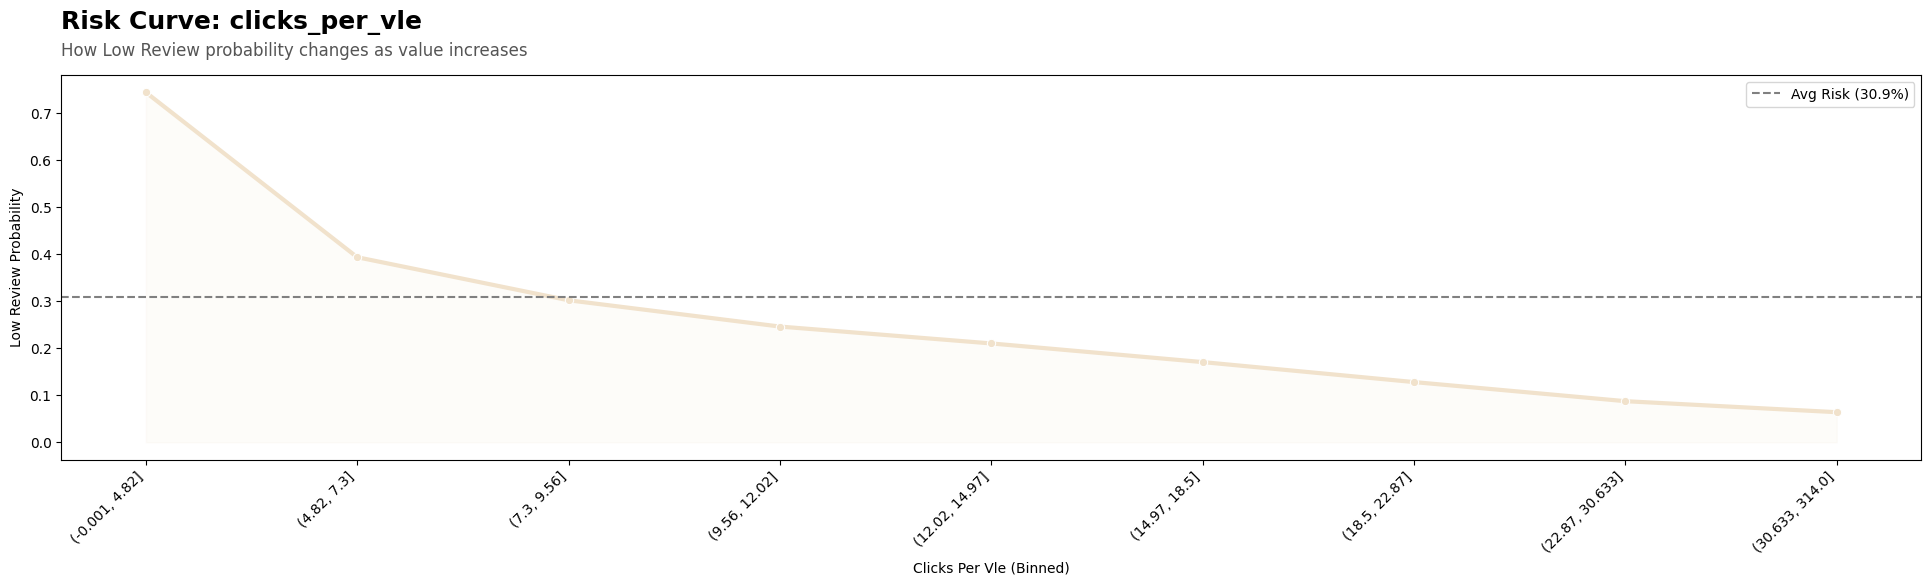

In [250]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'clicks_per_vle','final_result',bins = 10)

In [251]:
clicks_per_vle_groups = pd.cut(data['clicks_per_vle'], 
                         bins=[-1, 10,float('inf')], 
                         labels=['Under 10', 'Over 10'])

ct_clicks_per_vle = pd.crosstab(clicks_per_vle_groups, data['final_result'])

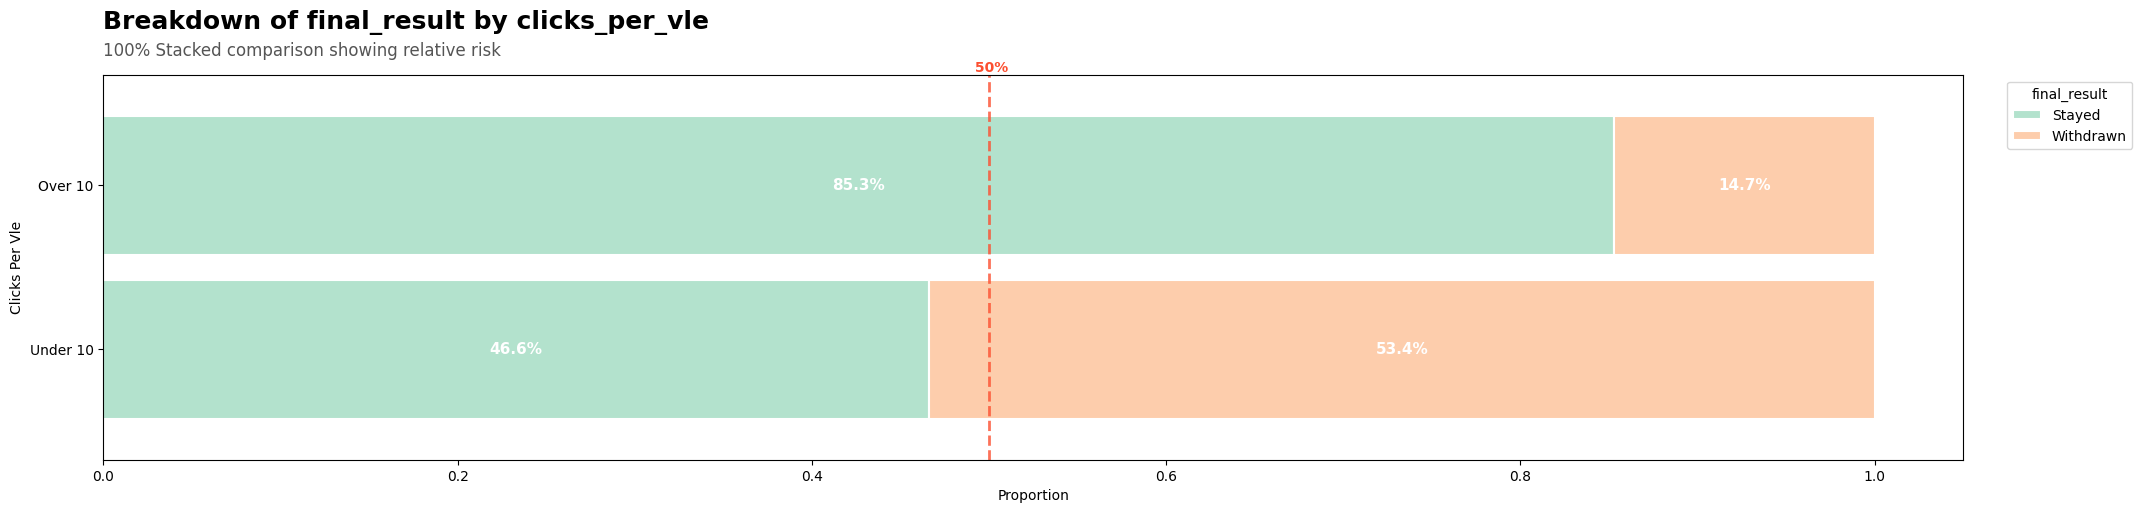

In [252]:
ct_clicks_per_vle_normalized = pd.crosstab(clicks_per_vle_groups, data['final_result'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_stacked(ct_clicks_per_vle_normalized,orient='h')

In [253]:
S.test_association(ct_clicks_per_vle)


=== Categorical Association Test ===
Test Used:      Chi-Square Test
P-Value:        0.00000
Verdict:        Significant Dependence ✅
Strength:       Cramer's V = 0.413 (Strong)


***
- ***by visuals we saw that `less than 10 clicks per vle have higher withdrawn values` - after doing statistical test we can validate this relationship with strong strength***
***